In [164]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib.dates as md
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [165]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [166]:
DAY22 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220602_R0_L1_20230915T130759.ict')
start_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 12:58:55"))
stop_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 13:10:00"))

DAY22_subset = DAY22[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY22_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,225948.0,0.000005,0.000005,1.270,NaN
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,341467.7,0.000004,0.000003,1.275,NaN
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,198596.5,0.000004,0.000003,1.275,NaN
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,158603.0,0.000005,0.000007,1.275,NaN
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,326062.3,0.000006,0.000007,1.285,NaN
...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,0.0,0.000000,0.000000,NaN,NaN
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,0.0,0.000000,0.000000,NaN,NaN
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,0.0,0.000000,0.000000,NaN,NaN
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,0.0,0.000000,0.000000,NaN,NaN


In [167]:
nbins = 20
bins = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins)
DAY22_subset_median = DAY22_subset.groupby('Bins').median()
DAY22_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(105.985, 291.908]",2022-06-02 12:59:12.000,2022-06-02 12:59:13.000,32.908859,-69.397118,182.2350,199531.80,0.000005,0.000005,1.3700,NaN
"(291.908, 477.83]",2022-06-02 12:59:41.000,2022-06-02 12:59:42.000,32.934998,-69.379643,388.9450,146233.20,0.000005,0.000005,1.3750,NaN
"(477.83, 663.753]",2022-06-02 13:00:05.000,2022-06-02 13:00:06.000,32.955627,-69.395696,571.9250,107159.20,0.000005,0.000005,1.3400,NaN
"(663.753, 849.676]",2022-06-02 13:00:27.500,2022-06-02 13:00:28.500,32.955277,-69.423800,763.2650,88005.60,0.000004,0.000003,1.2075,NaN
"(849.676, 1035.599]",2022-06-02 13:00:49.500,2022-06-02 13:00:50.500,32.936339,-69.440578,944.0275,80833.35,0.000005,0.000005,1.2175,NaN
"(1035.599, 1221.522]",2022-06-02 13:01:12.000,2022-06-02 13:01:13.000,32.911789,-69.433273,1120.2100,43680.70,0.000004,0.000003,0.9100,NaN
"(1221.522, 1407.444]",2022-06-02 13:01:35.500,2022-06-02 13:01:36.500,32.900627,-69.404055,1331.2700,33753.05,0.000004,0.000003,0.8650,NaN
"(1407.444, 1593.367]",2022-06-02 13:01:59.500,2022-06-02 13:02:00.500,32.910887,-69.373075,1494.2100,50145.90,0.000004,0.000003,0.8150,NaN
"(1593.367, 1779.29]",2022-06-02 13:02:22.000,2022-06-02 13:02:23.000,32.936250,-69.364681,1682.6500,45008.70,0.000004,0.000003,0.8800,NaN


In [168]:
DAY22_subset_25 = DAY22_subset_median - DAY22_subset.groupby('Bins').quantile(.25)
DAY22_subset_25
DAY22_subset_75 = DAY22_subset.groupby('Bins').quantile(.75) - DAY22_subset_median
DAY22_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(105.985, 291.908]",0 days 00:00:08,0 days 00:00:08,0.005096,0.008789,48.51500,107353.500,2.730000e-07,8.670000e-07,0.01500,NaN
"(291.908, 477.83]",0 days 00:00:06,0 days 00:00:06,0.006425,0.000766,40.48000,61418.900,7.390000e-07,5.920000e-07,0.01000,NaN
"(477.83, 663.753]",0 days 00:00:05.500000,0 days 00:00:05.500000,0.001940,0.006010,49.47000,57676.650,5.070000e-07,2.730000e-07,0.02250,NaN
"(663.753, 849.676]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.002122,0.006326,38.95250,37402.725,1.373250e-06,2.181750e-06,0.00625,NaN
"(849.676, 1035.599]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.005637,0.001915,40.55375,29051.475,1.454000e-06,1.562500e-06,0.04250,NaN
"(1035.599, 1221.522]",0 days 00:00:05.500000,0 days 00:00:05.500000,0.005465,0.005521,46.84500,45447.100,9.215000e-07,1.908500e-06,0.08250,NaN
"(1221.522, 1407.444]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.000862,0.008256,30.42500,34395.675,2.482500e-07,4.942500e-07,0.04000,NaN
"(1407.444, 1593.367]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.005764,0.004713,45.85500,21137.875,2.525000e-06,3.846000e-06,0.05500,NaN
"(1593.367, 1779.29]",0 days 00:00:05,0 days 00:00:05,0.005791,0.000575,46.45000,18084.700,7.420000e-07,1.703000e-06,0.01500,NaN


In [169]:
DAY2 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220602_R0_L1_20230915T130759.ict')
start_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 14:11:00"))

DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset



,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.0,0.000000,0.000000,0.415,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,26161.7,0.000004,0.000003,0.395,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.0,0.000000,0.000000,0.425,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,25703.0,0.000004,0.000003,0.450,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.0,0.000000,0.000000,0.440,NaN
...,...,...,...,...,...,...,...,...,...,...
10301,2022-06-02 14:10:55,2022-06-02 14:10:56,32.264343,-65.038703,3176.07,0.0,0.000000,0.000000,NaN,NaN
10302,2022-06-02 14:10:56,2022-06-02 14:10:57,32.263327,-65.039317,3180.14,0.0,0.000000,0.000000,NaN,NaN
10303,2022-06-02 14:10:57,2022-06-02 14:10:58,32.262289,-65.039886,3184.23,0.0,0.000000,0.000000,NaN,NaN
10304,2022-06-02 14:10:58,2022-06-02 14:10:59,32.261232,-65.040413,3188.41,0.0,0.000000,0.000000,NaN,NaN


In [170]:
nbins = 20
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_median = DAY2_subset.groupby('Bins').median()
DAY2_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(106.28, 260.607]",2022-06-02 13:58:07.000,2022-06-02 13:58:08.000,32.212884,-65.048915,129.9950,239709.00,0.000005,0.000006,1.4150,NaN
"(260.607, 414.935]",2022-06-02 13:59:23.500,2022-06-02 13:59:24.500,32.243630,-64.982119,312.9625,254731.20,0.000005,0.000006,1.4450,NaN
"(414.935, 569.262]",2022-06-02 13:55:05.000,2022-06-02 13:55:06.000,32.276937,-65.274051,449.9600,229769.80,0.000005,0.000006,1.5400,NaN
"(569.262, 723.59]",2022-06-02 14:00:59.500,2022-06-02 14:01:00.500,32.264739,-65.037435,658.1225,122647.80,0.000005,0.000005,1.5725,NaN
"(723.59, 877.917]",2022-06-02 14:01:34.500,2022-06-02 14:01:35.500,32.232674,-65.025610,784.5150,102401.50,0.000005,0.000005,1.6200,NaN
"(877.917, 1032.245]",2022-06-02 14:02:06.000,2022-06-02 14:02:07.000,32.231287,-64.985946,966.0450,78057.50,0.000005,0.000005,1.5750,NaN
"(1032.245, 1186.572]",2022-06-02 14:02:34.500,2022-06-02 14:02:35.500,32.256490,-64.955171,1107.9450,49526.55,0.000004,0.000005,1.4250,NaN
"(1186.572, 1340.9]",2022-06-02 14:03:11.500,2022-06-02 14:03:12.500,32.285203,-64.967662,1259.7850,35542.40,0.000004,0.000003,1.0575,NaN
"(1340.9, 1495.227]",2022-06-02 14:03:46.500,2022-06-02 14:03:47.500,32.287492,-65.008714,1410.3050,34783.85,0.000004,0.000003,0.9600,NaN


In [171]:
DAY2_subset_25 = DAY2_subset_median - DAY2_subset.groupby('Bins').quantile(.25)
DAY2_subset_25
DAY2_subset_75 = DAY2_subset.groupby('Bins').quantile(.75) - DAY2_subset_median
DAY2_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(106.28, 260.607]",0 days 00:00:38,0 days 00:00:38,0.011386,0.045676,43.15500,52107.000,6.500000e-07,9.520000e-07,0.04000,NaN
"(260.607, 414.935]",0 days 00:00:15.250000128,0 days 00:00:15.250000128,0.004031,0.007064,36.90000,129848.525,8.152500e-07,9.700000e-07,0.10250,NaN
"(414.935, 569.262]",0 days 00:01:06.500000,0 days 00:01:06.500000,0.014650,0.088544,32.04750,106561.400,9.230000e-07,1.120000e-06,0.05250,NaN
"(569.262, 723.59]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.046041,0.002170,32.76375,47495.700,7.372500e-07,1.079250e-06,0.13375,NaN
"(723.59, 877.917]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.083007,0.015434,39.46500,32225.850,6.462500e-07,8.900000e-07,0.12625,NaN
"(877.917, 1032.245]",0 days 00:00:09.500000,0 days 00:00:09.500000,0.089212,0.011983,29.57500,39104.450,5.070000e-07,2.730000e-07,0.06750,NaN
"(1032.245, 1186.572]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.067394,0.006049,36.28750,31466.575,7.580000e-07,5.470000e-07,0.04000,NaN
"(1186.572, 1340.9]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.012262,0.012110,40.45500,35860.525,1.500000e-06,2.250000e-06,0.14500,NaN
"(1340.9, 1495.227]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.042959,0.012559,35.74500,31773.325,1.144500e-06,2.079000e-06,0.34625,NaN


In [172]:
DAY2b = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220602_R0_L2_20230915T130759.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,38662.0,0.000005,0.000005,1.360,NaN
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,404071.8,0.000006,0.000006,1.330,NaN
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,238943.5,0.000006,0.000007,1.320,NaN
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,89972.5,0.000005,0.000005,1.340,NaN
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,315622.8,0.000009,0.000012,1.365,NaN
...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.0,0.000000,0.000000,NaN,NaN
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.0,0.000000,0.000000,NaN,NaN
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.0,0.000000,0.000000,NaN,NaN
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.0,0.000000,0.000000,NaN,NaN


In [173]:
nbins = 20
bins = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins)
DAY2b_subset_median = DAY2b_subset.groupby('Bins').median()
DAY2b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(132.5, 311.083]",2022-06-02 18:36:45.500,2022-06-02 18:36:46.500,32.282614,-65.035667,191.1225,179191.05,0.000005,0.000006,1.3400,NaN
"(311.083, 489.666]",2022-06-02 18:38:01.500,2022-06-02 18:38:02.500,32.240532,-64.982618,384.2900,36900.50,0.000004,0.000003,1.1675,NaN
"(489.666, 668.249]",2022-06-02 18:39:05.000,2022-06-02 18:39:06.000,32.290858,-64.989390,561.4700,74740.70,0.000004,0.000003,1.1750,NaN
"(668.249, 846.832]",2022-06-02 18:40:07.000,2022-06-02 18:40:08.000,32.258643,-65.021762,753.5350,50757.60,0.000004,0.000003,1.0800,NaN
"(846.832, 1025.415]",2022-06-02 18:41:01.500,2022-06-02 18:41:02.500,32.250738,-64.962283,940.4200,74828.50,0.000005,0.000005,1.1800,NaN
"(1025.415, 1203.998]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.9950,32511.65,0.000004,0.000003,0.9000,NaN
"(1203.998, 1382.581]",2022-06-02 18:42:45.500,2022-06-02 18:42:46.500,32.290507,-65.005753,1271.8950,32012.80,0.000004,0.000003,0.5975,NaN
"(1382.581, 1561.164]",2022-06-02 18:43:40.500,2022-06-02 18:43:41.500,32.247731,-64.973601,1479.7500,33574.90,0.000004,0.000003,0.3975,NaN
"(1561.164, 1739.747]",2022-06-02 18:44:32.000,2022-06-02 18:44:33.000,32.272387,-64.918661,1659.9700,34182.30,0.000004,0.000003,0.3075,NaN


In [174]:
DAY2b_subset_25 = DAY2b_subset_median - DAY2b_subset.groupby('Bins').quantile(.25)
DAY2b_subset_25
DAY2b_subset_75 = DAY2b_subset.groupby('Bins').quantile(.75) - DAY2b_subset_median
DAY2b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(132.5, 311.083]",0 days 00:00:22.250000128,0 days 00:00:22.250000128,0.021885,0.008480,43.36750,45266.025,5.767500e-07,8.095000e-07,0.03375,NaN
"(311.083, 489.666]",0 days 00:00:15.250000128,0 days 00:00:15.250000128,0.012638,0.012445,42.35625,57430.000,1.500000e-06,2.250000e-06,0.02625,NaN
"(489.666, 668.249]",0 days 00:00:16,0 days 00:00:16,0.003499,0.014844,53.97500,38089.600,1.500000e-06,2.250000e-06,0.05500,NaN
"(668.249, 846.832]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.013503,0.012284,48.51000,69668.100,1.195000e-06,2.113000e-06,0.07750,NaN
"(846.832, 1025.415]",0 days 00:00:12.250000128,0 days 00:00:12.250000128,0.009892,0.010450,29.91000,37794.100,5.070000e-07,2.730000e-07,0.07375,NaN
"(1025.415, 1203.998]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.007259,0.007432,41.51750,33158.025,9.930000e-07,1.977000e-06,0.05000,NaN
"(1203.998, 1382.581]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.011389,0.007551,54.45250,32127.225,9.302500e-07,1.908500e-06,0.10125,NaN
"(1382.581, 1561.164]",0 days 00:00:13.749999872,0 days 00:00:13.749999872,0.003726,0.018331,40.32000,9789.775,0.000000e+00,0.000000e+00,0.07750,NaN
"(1561.164, 1739.747]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.011928,0.004221,46.63500,18109.350,0.000000e+00,0.000000e+00,0.07125,NaN


In [175]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220607_R0_L1_20230915T130800.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,423746.3,0.000006,0.000008,0.615,NaN
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,301370.8,0.000004,0.000005,0.620,NaN
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,382696.6,0.000004,0.000005,0.625,NaN
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,488868.4,0.000004,0.000003,0.635,NaN
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,581981.2,0.000006,0.000007,0.640,NaN
...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,31856.7,0.000004,0.000003,NaN,NaN
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,0.0,0.000000,0.000000,NaN,NaN
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,0.0,0.000000,0.000000,NaN,NaN
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,0.0,0.000000,0.000000,NaN,NaN


In [176]:
nbins = 20
bins = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins)
DAY7_subset_median = DAY7_subset.groupby('Bins').median()
DAY7_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(125.87, 260.648]",2022-06-07 14:32:27.000,2022-06-07 14:32:28.000,32.229906,-64.976511,187.9700,497121.10,0.000005,0.000005,0.7400,NaN
"(260.648, 395.426]",2022-06-07 14:33:22.500,2022-06-07 14:33:23.500,32.182262,-65.000790,320.0050,504091.60,0.000005,0.000005,0.8050,NaN
"(395.426, 530.204]",2022-06-07 14:34:19.000,2022-06-07 14:34:20.000,32.207365,-65.046934,461.4850,611720.30,0.000005,0.000005,0.7950,NaN
"(530.204, 664.982]",2022-06-07 14:35:16.500,2022-06-07 14:35:17.500,32.234627,-65.007191,594.3025,625702.60,0.000005,0.000006,0.7150,NaN
"(664.982, 799.76]",2022-06-07 14:36:14.500,2022-06-07 14:36:15.500,32.188964,-64.983852,732.7375,602262.85,0.000005,0.000005,0.8475,NaN
"(799.76, 934.538]",2022-06-07 14:37:10.000,2022-06-07 14:37:11.000,32.176238,-65.041720,867.8700,318287.20,0.000005,0.000005,1.0450,NaN
"(934.538, 1069.316]",2022-06-07 14:38:02.000,2022-06-07 14:38:03.000,32.220114,-65.063618,994.2450,264035.40,0.000004,0.000003,1.0150,NaN
"(1069.316, 1204.094]",2022-06-07 14:38:51.000,2022-06-07 14:38:52.000,32.252250,-65.031225,1133.5100,357049.60,0.000004,0.000003,0.8050,NaN
"(1204.094, 1338.872]",2022-06-07 14:39:37.000,2022-06-07 14:39:38.000,32.232720,-64.985893,1270.7400,80150.20,0.000004,0.000003,0.8350,NaN


In [177]:
DAY7_subset_25 = DAY7_subset_median - DAY7_subset.groupby('Bins').quantile(.25)
DAY7_subset_25
DAY7_subset_75 = DAY7_subset.groupby('Bins').quantile(.75) - DAY7_subset_median
DAY7_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(125.87, 260.648]",0 days 00:00:13,0 days 00:00:13,0.011336,0.003252,31.67000,84860.100,1.507000e-06,3.345000e-06,0.0600,NaN
"(260.648, 395.426]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.005641,0.015637,29.24875,128896.700,1.617000e-06,4.803750e-06,0.0250,NaN
"(395.426, 530.204]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.012655,0.004133,30.89250,94714.950,2.116000e-06,4.771000e-06,0.0100,NaN
"(530.204, 664.982]",0 days 00:00:14.749999872,0 days 00:00:14.749999872,0.002633,0.015085,37.98625,145252.550,2.626750e-06,6.604000e-06,0.0150,NaN
"(664.982, 799.76]",0 days 00:00:13.749999872,0 days 00:00:13.749999872,0.013848,0.003731,33.29125,165585.875,1.838750e-06,4.563250e-06,0.0525,NaN
"(799.76, 934.538]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.009012,0.014638,31.83750,120390.200,4.575000e-07,9.915000e-07,0.0600,NaN
"(934.538, 1069.316]",0 days 00:00:12,0 days 00:00:12,0.010999,0.002238,44.29500,102328.100,2.180000e-07,1.794000e-06,0.0550,NaN
"(1069.316, 1204.094]",0 days 00:00:12,0 days 00:00:12,0.001751,0.014105,35.63000,92388.600,2.490000e-07,1.703000e-06,0.0250,NaN
"(1204.094, 1338.872]",0 days 00:00:10.500000,0 days 00:00:10.500000,0.009505,0.002794,32.42000,92561.150,4.930000e-07,0.000000e+00,0.0750,NaN


In [178]:
DAY7b = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220607_R0_L2_20230915T130800.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset =DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,755180.0,0.000005,0.000006,NaN,NaN
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,522185.9,0.000006,0.000006,NaN,NaN
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,470538.5,0.000011,0.000014,NaN,NaN
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,545208.6,0.000005,0.000003,NaN,NaN
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,607779.2,0.000005,0.000005,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.0,0.000000,0.000000,NaN,NaN
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,80012.7,0.000004,0.000003,NaN,NaN
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.0,0.000000,0.000000,NaN,NaN
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.0,0.000000,0.000000,NaN,NaN


In [179]:
nbins = 20
bins = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins)
DAY7b_subset_median = DAY7b_subset.groupby('Bins').median()
DAY7b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(132.595, 303.26]",2022-06-07 19:08:28.000,2022-06-07 19:08:29.000,32.257846,-64.976147,210.165,470538.5,0.000005,0.000005,NaN,NaN
"(303.26, 473.926]",2022-06-07 19:09:23.000,2022-06-07 19:09:24.000,32.299892,-65.003903,388.610,495852.2,0.000005,0.000006,NaN,NaN
"(473.926, 644.591]",2022-06-07 19:10:16.000,2022-06-07 19:10:17.000,32.270860,-65.050200,553.840,545720.6,0.000006,0.000006,NaN,NaN
"(644.591, 815.256]",2022-06-07 19:11:06.000,2022-06-07 19:11:07.000,32.236773,-65.016539,727.605,660143.2,0.000007,0.000007,NaN,NaN
"(815.256, 985.921]",2022-06-07 19:11:57.000,2022-06-07 19:11:58.000,32.268496,-64.981012,894.580,717410.9,0.000006,0.000006,NaN,NaN
"(985.921, 1156.586]",2022-06-07 19:12:50.000,2022-06-07 19:12:51.000,32.297975,-65.025065,1079.310,461481.2,0.000005,0.000006,NaN,NaN
"(1156.586, 1327.252]",2022-06-07 19:13:46.000,2022-06-07 19:13:47.000,32.254313,-65.055631,1249.830,0.0,0.000000,0.000000,NaN,NaN
"(1327.252, 1497.917]",2022-06-07 19:14:42.000,2022-06-07 19:14:43.000,32.235256,-64.999635,1404.740,0.0,0.000000,0.000000,NaN,NaN
"(1497.917, 1668.582]",2022-06-07 19:15:35.500,2022-06-07 19:15:36.500,32.283800,-64.989856,1578.760,0.0,0.000000,0.000000,NaN,NaN


In [180]:

DAY7b_subset_25 = DAY7b_subset_median - DAY7b_subset.groupby('Bins').quantile(.25)
DAY7b_subset_25
DAY7b_subset_75 = DAY7b_subset.groupby('Bins').quantile(.75) - DAY7b_subset_median
DAY7b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(132.595, 303.26]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.013547,0.002931,37.7050,70737.90,8.350000e-07,0.000001,NaN,NaN
"(303.26, 473.926]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.002504,0.015890,38.4625,81720.60,1.952000e-06,0.000004,NaN,NaN
"(473.926, 644.591]",0 days 00:00:12.500000,0 days 00:00:12.500000,0.013278,0.003860,44.6375,75700.55,1.430500e-06,0.000004,NaN,NaN
"(644.591, 815.256]",0 days 00:00:12,0 days 00:00:12,0.003080,0.014534,39.2300,137870.00,7.950000e-07,0.000003,NaN,NaN
"(815.256, 985.921]",0 days 00:00:13,0 days 00:00:13,0.013432,0.002435,48.8150,95965.90,1.866000e-06,0.000006,NaN,NaN
"(985.921, 1156.586]",0 days 00:00:13,0 days 00:00:13,0.002024,0.016621,38.6100,175342.30,8.150000e-07,0.000001,NaN,NaN
"(1156.586, 1327.252]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.015633,0.007776,38.2500,140429.30,3.996500e-06,0.000003,NaN,NaN
"(1327.252, 1497.917]",0 days 00:00:13,0 days 00:00:13,0.009127,0.011747,44.8000,0.00,0.000000e+00,0.000000,NaN,NaN
"(1497.917, 1668.582]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.008584,0.007586,44.5350,0.00,0.000000e+00,0.000000,NaN,NaN


In [181]:
DAY8 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220608_R0_L2_20230915T130801.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,337642.6,0.000005,0.000005,0.695,NaN
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,230861.1,0.000004,0.000003,0.715,NaN
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,518915.4,0.000004,0.000003,0.730,NaN
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,304042.3,0.000005,0.000005,0.740,NaN
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,257635.5,0.000004,0.000003,0.725,NaN
...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.0,0.000000,0.000000,NaN,1.42
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.0,0.000000,0.000000,NaN,1.23
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.0,0.000000,0.000000,NaN,1.15
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.0,0.000000,0.000000,NaN,1.24


In [182]:
nbins = 20
bins = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins)
DAY8_subset_median = DAY8_subset.groupby('Bins').median()
DAY8_subset_median
DAY8_subset_25 = DAY8_subset_median - DAY8_subset.groupby('Bins').quantile(.25)
DAY8_subset_25
DAY8_subset_75 = DAY8_subset.groupby('Bins').quantile(.75) - DAY8_subset_median
DAY8_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(147.455, 333.705]",0 days 00:00:27,0 days 00:00:27,0.007854,0.035028,64.2550,1.407853e+05,6.460000e-07,1.035000e-06,0.13500,NaN
"(333.705, 519.956]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.008836,0.014153,42.6200,1.522501e+05,6.722500e-07,1.119250e-06,0.03625,NaN
"(519.956, 706.206]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.014929,0.006504,44.2025,8.575750e+04,5.605000e-07,7.505000e-07,0.04500,NaN
"(706.206, 892.456]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.003217,0.013764,48.1300,1.564332e+05,1.230500e-06,3.903000e-06,0.07250,NaN
"(892.456, 1078.706]",0 days 00:00:15,0 days 00:00:15,0.014171,0.003605,48.4600,9.633761e+07,1.640000e-06,2.160000e-06,0.38500,NaN
"(1078.706, 1264.956]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.004731,0.016424,46.0750,2.400971e+05,7.115000e-07,6.150000e-07,0.05000,NaN
"(1264.956, 1451.207]",0 days 00:00:16.749999872,0 days 00:00:16.749999872,0.008973,0.004759,36.2825,0.000000e+00,0.000000e+00,0.000000e+00,0.16625,NaN
"(1451.207, 1637.457]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.009496,0.006688,52.9550,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
"(1637.457, 1823.707]",0 days 00:00:10.749999872,0 days 00:00:10.749999872,0.008963,0.009932,46.5500,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN


In [183]:
DAY10 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220610_R0_L1_20230915T130802.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,830151.8,0.000005,0.000005,NaN,NaN
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,971761.4,0.000006,0.000006,NaN,NaN
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,1691204.9,0.000005,0.000005,NaN,NaN
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,747160.7,0.000005,0.000005,NaN,NaN
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,807571.9,0.000007,0.000008,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,0.0,0.000000,0.000000,NaN,NaN
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,0.0,0.000000,0.000000,NaN,NaN
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,24869.1,0.000005,0.000005,NaN,NaN
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,0.0,0.000000,0.000000,NaN,NaN


In [184]:
nbins = 20
bins = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins)
DAY10_subset_median = DAY10_subset.groupby('Bins').median()
DAY10_subset_median
DAY10_subset_25 = DAY10_subset_median - DAY10_subset.groupby('Bins').quantile(.25)
DAY10_subset_25
DAY10_subset_75 = DAY10_subset.groupby('Bins').quantile(.75) - DAY10_subset_median
DAY10_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(122.04, 294.274]",0 days 00:00:17,0 days 00:00:17,0.019265,0.003430,46.49000,563147.600,7.730000e-07,9.540000e-07,NaN,NaN
"(294.274, 466.509]",0 days 00:00:05,0 days 00:00:05,0.003220,0.004873,42.82500,209924.700,1.160000e-07,1.010000e-07,NaN,NaN
"(466.509, 638.743]",0 days 00:00:05,0 days 00:00:05,0.000502,0.006371,41.04500,157235.200,5.470000e-07,6.500000e-07,NaN,NaN
"(638.743, 810.978]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.001362,0.005948,39.60000,111716.400,4.530000e-07,4.100000e-07,NaN,NaN
"(810.978, 983.212]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.003760,0.004314,42.35375,55515.200,3.800000e-07,6.540000e-07,NaN,NaN
"(983.212, 1155.447]",0 days 00:00:04.500000,0 days 00:00:04.500000,0.004850,0.001614,40.62500,66502.500,5.070000e-07,2.730000e-07,NaN,NaN
"(1155.447, 1327.682]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.005316,0.002019,41.13500,28934.125,3.285000e-07,5.757500e-07,NaN,NaN
"(1327.682, 1499.916]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.004214,0.004939,41.76500,71265.350,5.267500e-07,5.867500e-07,NaN,NaN
"(1499.916, 1672.15]",0 days 00:00:05,0 days 00:00:05,0.002058,0.006995,39.61000,29894.200,1.890000e-07,8.670000e-07,NaN,NaN


In [185]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220610_R0_L2_20230915T130802.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
DAY110b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,256015.6,0.000004,0.000003,0.630,NaN
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,534635.9,0.000005,0.000005,0.625,NaN
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,803761.2,0.000005,0.000005,0.620,NaN
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,682863.7,0.000005,0.000005,0.615,NaN
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,627391.4,0.000005,0.000006,0.615,NaN
...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,0.0,0.000000,0.000000,NaN,1.120
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,0.0,0.000000,0.000000,NaN,1.070
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,0.0,0.000000,0.000000,NaN,1.155
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,0.0,0.000000,0.000000,NaN,1.230


In [186]:
nbins = 20
bins = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins)
DAY110b_subset_median = DAY110b_subset.groupby('Bins').median()
DAY110b_subset_median
DAY110b_subset_25 = DAY110b_subset_median - DAY110b_subset.groupby('Bins').quantile(.25)
DAY110b_subset_25
DAY110b_subset_75 = DAY110b_subset.groupby('Bins').quantile(.75) - DAY110b_subset_median
DAY110b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(112.97, 357.058]",0 days 00:01:18,0 days 00:01:18,0.052221,0.078943,2.26500,237139.200,5.660000e-07,5.460000e-07,0.06500,NaN
"(357.058, 601.145]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.007922,0.011272,63.13875,128117.400,5.865000e-07,6.462500e-07,0.00875,NaN
"(601.145, 845.233]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.004252,0.009937,59.90500,174898.900,7.910000e-07,1.016500e-06,0.02500,NaN
"(845.233, 1089.32]",0 days 00:00:10.749999872,0 days 00:00:10.749999872,0.009107,0.006360,56.24500,131815.975,8.347500e-07,1.503250e-06,0.03625,NaN
"(1089.32, 1333.408]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.012293,0.009116,55.20000,85103.900,6.390000e-07,1.014000e-06,0.03250,NaN
"(1333.408, 1577.495]",0 days 00:00:08.749999872,0 days 00:00:08.749999872,0.002226,0.011545,69.47250,77393.650,4.635000e-07,2.730000e-07,0.22000,NaN
"(1577.495, 1821.582]",0 days 00:00:09.250000128,0 days 00:00:09.250000128,0.006932,0.005957,45.91250,35773.875,5.170000e-07,3.905000e-07,0.09625,NaN
"(1821.582, 2065.67]",0 days 00:00:11,0 days 00:00:11,0.009504,0.007338,42.74000,40665.200,7.580000e-07,5.470000e-07,0.02500,NaN
"(2065.67, 2309.757]",0 days 00:00:09.250000128,0 days 00:00:09.250000128,0.006977,0.009989,55.74000,2609.575,5.565000e-07,1.277250e-06,0.06000,NaN


In [187]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220610_R0_L2_20230915T130802.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,195937.3,0.000005,0.000006,0.215,NaN
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,139344.5,0.000006,0.000007,0.225,NaN
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,162837.0,0.000004,0.000003,0.235,NaN
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,143985.2,0.000004,0.000003,0.250,NaN
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,219310.7,0.000004,0.000003,0.265,NaN
...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,0.0,0.000000,0.000000,NaN,NaN
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,0.0,0.000000,0.000000,NaN,NaN
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,0.0,0.000000,0.000000,NaN,NaN
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,0.0,0.000000,0.000000,NaN,NaN


In [188]:
nbins = 20
bins = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins)
DAY10b_subset_median = DAY10b_subset.groupby('Bins').median()
DAY10b_subset_median
DAY10b_subset_25 = DAY10b_subset_median - DAY10b_subset.groupby('Bins').quantile(.25)
DAY10b_subset_25
DAY10b_subset_75 = DAY10b_subset.groupby('Bins').quantile(.75) - DAY10b_subset_median
DAY10b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(119.575, 360.352]",0 days 00:00:30.749999872,0 days 00:00:30.749999872,0.026552,0.025628,11.53625,680759.200,8.207500e-07,9.005000e-07,0.14250,NaN
"(360.352, 601.128]",0 days 00:00:05,0 days 00:00:05,0.005345,0.000487,63.40000,161457.100,1.020000e-06,1.400000e-06,0.01000,NaN
"(601.128, 841.905]",0 days 00:00:04,0 days 00:00:04,0.002334,0.003576,59.49000,60860.500,5.140000e-07,8.840000e-07,0.01000,NaN
"(841.905, 1082.682]",0 days 00:00:03.500000,0 days 00:00:03.500000,0.000212,0.003939,53.93000,106163.650,4.975000e-07,9.835000e-07,0.01250,NaN
"(1082.682, 1323.459]",0 days 00:00:03.749999872,0 days 00:00:03.749999872,0.001746,0.003474,56.76750,287325.050,5.850000e-07,7.655000e-07,0.03375,NaN
"(1323.459, 1564.236]",0 days 00:00:03.500000,0 days 00:00:03.500000,0.002901,0.001489,54.35500,8293.100,6.890000e-07,2.159000e-06,0.05500,NaN
"(1564.236, 1805.012]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.004838,0.003293,59.75250,73702.525,5.650000e-07,3.597500e-07,0.04625,NaN
"(1805.012, 2045.789]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.002513,0.007255,57.54000,111416.775,7.580000e-07,5.470000e-07,0.09125,NaN
"(2045.789, 2286.566]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.001430,0.006285,55.54750,8616.450,9.375000e-07,7.500000e-07,0.02875,NaN


In [120]:
DAY11 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220611_R0_L1_20230915T130803.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,564058.5,0.000006,0.000006,0.640,NaN
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,521268.9,0.000004,0.000005,0.630,NaN
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,571274.1,0.000006,0.000008,0.630,NaN
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,843624.0,0.000006,0.000006,0.630,NaN
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,606233.8,0.000007,0.000009,0.625,NaN
...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.0,0.000000,0.000000,NaN,0.885
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.0,0.000000,0.000000,NaN,0.920
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.0,0.000000,0.000000,NaN,1.040
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.0,0.000000,0.000000,NaN,1.120


In [189]:
nbins = 20
bins = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins)
DAY11_subset_median = DAY11_subset.groupby('Bins').median()
DAY11_subset_median
DAY11_subset_25 = DAY11_subset_median - DAY11_subset.groupby('Bins').quantile(.25)
DAY11_subset_25
DAY11_subset_75 = DAY11_subset.groupby('Bins').quantile(.75) - DAY11_subset_median
DAY11_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(137.295, 366.776]",0 days 00:00:38.749999872,0 days 00:00:38.749999872,0.019737,0.028329,63.0975,172830.675,8.650000e-07,1.762250e-06,0.12000,NaN
"(366.776, 596.256]",0 days 00:00:17,0 days 00:00:17,0.014132,0.003947,51.5150,152773.800,1.983000e-06,4.151000e-06,0.16500,NaN
"(596.256, 825.737]",0 days 00:00:11,0 days 00:00:11,0.007106,0.012731,69.3450,93558.400,1.470000e-06,3.866000e-06,0.03500,NaN
"(825.737, 1055.218]",0 days 00:00:16.500000,0 days 00:00:16.500000,0.005502,0.020452,71.6350,161847.100,1.626000e-06,2.506000e-06,0.03500,NaN
"(1055.218, 1284.699]",0 days 00:00:16,0 days 00:00:16,0.016132,0.004144,50.3300,128043.600,1.744000e-06,3.754000e-06,0.01500,NaN
"(1284.699, 1514.18]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.010896,0.014797,60.1850,108810.450,1.187000e-06,1.728000e-06,0.06500,NaN
"(1514.18, 1743.66]",0 days 00:00:18.250000128,0 days 00:00:18.250000128,0.005987,0.022828,64.3225,116480.925,2.005000e-06,4.810000e-06,0.01625,NaN
"(1743.66, 1973.141]",0 days 00:00:17.250000128,0 days 00:00:17.250000128,0.007032,0.014948,59.8675,64001.050,4.530000e-07,4.445000e-07,0.06000,NaN
"(1973.141, 2202.622]",0 days 00:00:20.500000,0 days 00:00:20.500000,0.012450,0.023227,47.8250,27375.100,7.580000e-07,5.470000e-07,0.09500,NaN


In [190]:
DAY11b = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220611_R0_L2_20230915T130803.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,686696.6,0.000006,0.000006,0.390,NaN
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,551397.5,0.000005,0.000005,0.355,NaN
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,559293.4,0.000008,0.000009,0.330,NaN
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,597724.1,0.000006,0.000007,0.325,NaN
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,677764.4,0.000005,0.000005,0.335,NaN
...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,0.0,0.000000,0.000000,0.200,NaN
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,0.0,0.000000,0.000000,0.115,NaN
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,0.0,0.000000,0.000000,0.030,NaN
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,54184.8,0.000006,0.000007,0.030,NaN


In [191]:
nbins = 20
bins = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins)
DAY11b_subset_median = DAY11b_subset.groupby('Bins').median()
DAY11b_subset_median
DAY11b_subset_25 = DAY11b_subset_median - DAY11b_subset.groupby('Bins').quantile(.25)
DAY11b_subset_25
DAY11b_subset_75 = DAY11b_subset.groupby('Bins').quantile(.75) - DAY11b_subset_median
DAY11b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(108.925, 261.267]",0 days 00:00:07.250000128,0 days 00:00:07.250000128,0.000770,0.010359,58.7275,169878.975,6.185000e-07,7.235000e-07,0.01375,NaN
"(261.267, 413.609]",0 days 00:00:04.500000,0 days 00:00:04.500000,0.002125,0.004829,31.8250,82444.550,1.535000e-06,3.188500e-06,0.00500,NaN
"(413.609, 565.952]",0 days 00:00:06.250000128,0 days 00:00:06.250000128,0.006338,0.001489,33.6925,117401.175,6.597500e-07,7.307500e-07,0.02000,NaN
"(565.952, 718.294]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.001687,0.006795,29.1200,103778.100,4.385000e-07,7.610000e-07,0.05125,NaN
"(718.294, 870.636]",0 days 00:00:05,0 days 00:00:05,0.002913,0.004188,26.8000,58087.700,5.240000e-07,1.209000e-06,0.04000,NaN
"(870.636, 1022.978]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.005519,0.000637,28.8475,71092.625,1.469000e-06,1.823500e-06,0.00875,NaN
"(1022.978, 1175.321]",0 days 00:00:04,0 days 00:00:04,0.002185,0.004282,34.8000,68546.400,8.310000e-07,1.226000e-06,0.00500,NaN
"(1175.321, 1327.663]",0 days 00:00:04,0 days 00:00:04,0.001925,0.004800,32.9200,118085.700,9.070000e-07,2.250000e-06,0.00500,NaN
"(1327.663, 1480.005]",0 days 00:00:03.749999872,0 days 00:00:03.749999872,0.003736,0.002654,42.1600,105572.475,2.265000e-07,7.005000e-07,0.05000,NaN


In [192]:
DAY13 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220613_R0_L1_20230915T130804.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,318829.5,0.000006,0.000006,0.850,NaN
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,509800.4,0.000005,0.000005,0.865,NaN
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,823946.2,0.000005,0.000006,0.880,NaN
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,615983.3,0.000006,0.000006,0.885,NaN
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,568629.6,0.000006,0.000006,0.890,NaN
...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.0,0.000000,0.000000,NaN,1.285
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.0,0.000000,0.000000,NaN,1.400
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.0,0.000000,0.000000,NaN,1.440
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.0,0.000000,0.000000,NaN,1.410


In [193]:
nbins = 20
bins = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins)
DAY13_subset_median = DAY13_subset.groupby('Bins').median()
DAY13_subset_median
DAY13_subset_25 = DAY13_subset_median - DAY13_subset.groupby('Bins').quantile(.25)
DAY13_subset_25
DAY13_subset_75 = DAY13_subset.groupby('Bins').quantile(.75) - DAY13_subset_median
DAY13_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(138.195, 358.368]",0 days 00:00:28,0 days 00:00:28,0.030130,0.010359,112.47000,205341.600,9.180000e-07,0.000001,0.13000,NaN
"(358.368, 578.542]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.002181,0.019058,54.09625,62140.450,6.960000e-07,0.000001,0.42250,NaN
"(578.542, 798.715]",0 days 00:00:14.749999872,0 days 00:00:14.749999872,0.016774,0.006472,62.55000,124270.500,1.383250e-06,0.000002,0.04625,NaN
"(798.715, 1018.888]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.003778,0.018661,48.48500,83353.425,1.305750e-06,0.000003,0.03375,NaN
"(1018.888, 1239.061]",0 days 00:00:16.250000128,0 days 00:00:16.250000128,0.017967,0.003437,41.75000,139094.775,1.351750e-06,0.000003,0.04500,NaN
"(1239.061, 1459.234]",0 days 00:00:18,0 days 00:00:18,0.003568,0.024420,38.70000,273346.800,1.343000e-06,0.000004,0.07500,NaN
"(1459.234, 1679.408]",0 days 00:00:18.250000128,0 days 00:00:18.250000128,0.020121,0.018396,55.16250,140631.225,1.213500e-06,0.000002,0.10000,NaN
"(1679.408, 1899.581]",0 days 00:00:17.749999872,0 days 00:00:17.749999872,0.017841,0.012524,60.04750,97872.425,1.927250e-06,0.000004,0.01500,NaN
"(1899.581, 2119.754]",0 days 00:00:18.500000,0 days 00:00:18.500000,0.006497,0.016531,66.25000,80807.100,1.988000e-06,0.000003,0.04750,NaN


In [194]:
DAY13b = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220613_R0_L2_20230915T130804.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,72771.0,0.000008,0.000009,0.605,NaN
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,146698.2,0.000006,0.000006,0.560,NaN
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,100434.6,0.000005,0.000005,0.500,NaN
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,40310.2,0.000004,0.000003,0.480,NaN
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,388067.2,0.000005,0.000006,0.415,NaN
...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.0,0.000000,0.000000,NaN,1.325
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.0,0.000000,0.000000,NaN,1.235
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.0,0.000000,0.000000,NaN,1.180
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.0,0.000000,0.000000,NaN,1.190


In [195]:
nbins = 20
bins = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins)
DAY13b_subset_median = DAY13b_subset.groupby('Bins').median()
DAY13b_subset_median
DAY13b_subset_25 = DAY13b_subset_median - DAY13b_subset.groupby('Bins').quantile(.25)
DAY13b_subset_25
DAY13b_subset_75 = DAY13b_subset.groupby('Bins').quantile(.75) - DAY13b_subset_median
DAY13b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(105.59, 329.686]",0 days 00:00:25.250000128,0 days 00:00:25.250000128,0.010465,0.025778,85.43875,86206.075,5.605000e-07,1.035250e-06,0.04375,NaN
"(329.686, 553.781]",0 days 00:00:15.749999872,0 days 00:00:15.749999872,0.002415,0.014763,57.57375,76973.550,5.070000e-07,2.730000e-07,0.04875,NaN
"(553.781, 777.876]",0 days 00:00:16.500000,0 days 00:00:16.500000,0.015576,0.006068,56.09750,43253.950,1.094000e-06,2.045000e-06,0.17500,NaN
"(777.876, 1001.972]",0 days 00:00:17.250000128,0 days 00:00:17.250000128,0.018314,0.004672,49.19125,45480.725,1.253500e-06,2.250000e-06,0.01500,NaN
"(1001.972, 1226.067]",0 days 00:00:14,0 days 00:00:14,0.002129,0.015698,56.45000,92803.500,1.674000e-06,3.064000e-06,0.01000,NaN
"(1226.067, 1450.163]",0 days 00:00:20,0 days 00:00:20,0.020834,0.007982,65.12000,173831.700,1.209000e-06,2.969000e-06,0.01500,NaN
"(1450.163, 1674.258]",0 days 00:00:33.749999872,0 days 00:00:33.749999872,0.031172,0.014914,58.66000,243256.200,1.568500e-06,2.910500e-06,0.03250,NaN
"(1674.258, 1898.354]",0 days 00:00:44.500000,0 days 00:00:44.500000,0.022624,0.036494,63.18000,251439.950,9.600000e-07,2.040000e-06,0.01000,NaN
"(1898.354, 2122.449]",0 days 00:00:39.250000128,0 days 00:00:39.250000128,0.025898,0.031207,64.71000,199436.850,1.199250e-06,3.140500e-06,0.02000,NaN


In [196]:
DAY14 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220614_R0_20230915T130804.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,171759.8,0.000005,0.000005,0.400,NaN
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,113588.5,0.000004,0.000003,0.380,NaN
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,116074.4,0.000010,0.000011,0.375,NaN
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,103348.6,0.000004,0.000003,0.355,NaN
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,78065.0,0.000005,0.000005,0.325,NaN
...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.0,0.000000,0.000000,0.115,0.995
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.0,0.000000,0.000000,0.140,1.365
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.0,0.000000,0.000000,0.140,1.735
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.0,0.000000,0.000000,0.140,1.850


In [197]:
nbins = 20
bins = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins)
DAY14_subset_median = DAY14_subset.groupby('Bins').median()
DAY14_subset_median
DAY14_subset_25 = DAY14_subset_median - DAY14_subset.groupby('Bins').quantile(.25)
DAY14_subset_25
DAY14_subset_75 = DAY14_subset.groupby('Bins').quantile(.75) - DAY14_subset_median
DAY14_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(117.0, 535.166]",0 days 00:00:20,0 days 00:00:20,0.016945,0.020369,158.20500,77601.800,7.210000e-07,1.158000e-06,0.15500,NaN
"(535.166, 953.333]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.002846,0.013087,97.72375,84852.400,7.940000e-07,9.575000e-07,0.16750,NaN
"(953.333, 1371.5]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.008928,0.007774,104.64000,153157.925,1.492250e-06,2.585500e-06,0.03000,NaN
"(1371.5, 1789.666]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.012780,0.004222,102.78000,75579.325,2.119000e-06,3.490500e-06,0.02500,NaN
"(1789.666, 2207.832]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.002138,0.014201,100.31500,52699.450,9.215000e-07,1.908500e-06,0.05250,NaN
"(2207.832, 2625.999]",0 days 00:00:12.250000128,0 days 00:00:12.250000128,0.013057,0.002912,116.56250,81551.875,1.500000e-06,2.250000e-06,0.03500,NaN
"(2625.999, 3044.166]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.013603,0.012794,84.36000,0.000,0.000000e+00,0.000000e+00,0.41375,NaN
"(3044.166, 3462.332]",0 days 00:00:12,0 days 00:00:12,0.002493,0.016610,94.40000,0.000,0.000000e+00,0.000000e+00,NaN,NaN
"(3462.332, 3880.498]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.015262,0.003727,108.68500,0.000,0.000000e+00,0.000000e+00,NaN,0.09625


In [198]:
DAY17 = simple_read('C:/Users/taiwoajayi/Documents/FCDP/activate-mrg1_hu25_20220617_R0_20230915T130805.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,554378.4,0.000004,0.000005,-0.230,NaN
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,183421.5,0.000006,0.000007,-0.225,NaN
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,268403.7,0.000004,0.000005,-0.210,NaN
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,376277.1,0.000005,0.000005,-0.180,NaN
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,294599.9,0.000005,0.000006,-0.170,NaN
...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.0,0.000000,0.000000,NaN,1.315
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.0,0.000000,0.000000,NaN,1.370
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.0,0.000000,0.000000,NaN,1.435
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.0,0.000000,0.000000,NaN,1.420


In [199]:
nbins = 20
bins = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins)
DAY17_subset_median = DAY17_subset.groupby('Bins').median()
DAY17_subset_median
DAY17_subset_25 = DAY17_subset_median - DAY17_subset.groupby('Bins').quantile(.25)
DAY17_subset_25
DAY17_subset_75 = DAY17_subset.groupby('Bins').quantile(.75) - DAY17_subset_median
DAY17_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(124.73, 501.808]",0 days 00:00:41.250000128,0 days 00:00:41.250000128,0.018728,0.016713,128.98125,121768.05,4.802500e-07,7.025000e-07,0.09875,NaN
"(501.808, 878.885]",0 days 00:00:26,0 days 00:00:26,0.008572,0.010748,98.45000,116018.90,5.600000e-07,7.130000e-07,0.10000,NaN
"(878.885, 1255.962]",0 days 00:01:18.500000,0 days 00:01:18.500000,0.021372,0.023681,1.42000,458317.20,1.467500e-06,1.987500e-06,0.26000,NaN
"(1255.962, 1633.04]",0 days 00:00:33.250000128,0 days 00:00:33.250000128,0.035941,0.022201,88.02500,146408.30,8.175000e-07,9.570000e-07,0.04750,NaN
"(1633.04, 2010.117]",0 days 00:00:32.500000,0 days 00:00:32.500000,0.013719,0.036169,96.44000,309691.65,1.430500e-06,1.810000e-06,0.28500,NaN
"(2010.117, 2387.195]",0 days 00:00:22.749999872,0 days 00:00:22.749999872,0.022723,0.008771,97.94000,0.00,0.000000e+00,0.000000e+00,NaN,NaN
"(2387.195, 2764.272]",0 days 00:00:14,0 days 00:00:14,0.003043,0.018270,99.41000,0.00,0.000000e+00,0.000000e+00,NaN,NaN
"(2764.272, 3141.35]",0 days 00:00:13,0 days 00:00:13,0.013954,0.013775,91.98000,0.00,0.000000e+00,0.000000e+00,0.65000,0.08000
"(3141.35, 3518.428]",0 days 00:00:12,0 days 00:00:12,0.011488,0.008179,87.37000,0.00,0.000000e+00,0.000000e+00,0.50000,0.04500


In [200]:
nbins = 100
bins_1000 = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY22_subset_1000 = DAY22_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY22_subset_1000[start_index:stop_index]
DAY1000_subset_1000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(105.985, 143.17]",2022-06-02 12:59:00.500,2022-06-02 12:59:01.500,32.903514,-69.411194,113.9000,179353.70,0.000005,0.000005,1.3050,NaN
"(143.17, 180.354]",2022-06-02 12:59:09.500,2022-06-02 12:59:10.500,32.907635,-69.400132,160.4275,113631.25,0.000005,0.000005,1.3900,NaN
"(180.354, 217.539]",2022-06-02 12:59:14.500,2022-06-02 12:59:15.500,32.910235,-69.394203,199.8250,253208.55,0.000006,0.000008,1.3775,NaN
"(217.539, 254.723]",2022-06-02 12:59:20.500,2022-06-02 12:59:21.500,32.914346,-69.387850,234.4575,244891.30,0.000005,0.000006,1.3800,NaN
"(254.723, 291.908]",2022-06-02 12:59:26.000,2022-06-02 12:59:27.000,32.919085,-69.383209,276.6850,225050.50,0.000005,0.000006,1.3750,NaN
"(291.908, 329.092]",2022-06-02 12:59:32.000,2022-06-02 12:59:33.000,32.925125,-69.379793,304.7050,146233.20,0.000006,0.000006,1.3800,NaN
"(329.092, 366.277]",2022-06-02 12:59:37.000,2022-06-02 12:59:38.000,32.930599,-69.378595,345.2250,130009.10,0.000005,0.000005,1.3800,NaN
"(366.277, 403.461]",2022-06-02 12:59:40.500,2022-06-02 12:59:41.500,32.934451,-69.378665,383.8625,258562.85,0.000005,0.000004,1.3375,NaN
"(403.461, 440.646]",2022-06-02 12:59:45.500,2022-06-02 12:59:46.500,32.939847,-69.379819,420.9575,142394.75,0.000005,0.000005,1.3800,NaN


In [201]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY22_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(998.414, 1035.599]",2022-06-02 13:00:58.500,2022-06-02 13:00:59.500,32.926077,-69.440875,1020.465,54666.00,0.000004,0.000004,1.1100,NaN
"(1035.599, 1072.783]",2022-06-02 13:01:03.000,2022-06-02 13:01:04.000,32.921032,-69.439333,1057.400,65924.00,0.000004,0.000003,1.0300,NaN
"(1072.783, 1109.968]",2022-06-02 13:01:08.000,2022-06-02 13:01:09.000,32.915694,-69.436460,1089.620,73534.80,0.000004,0.000003,0.9550,NaN
"(1109.968, 1147.152]",2022-06-02 13:01:13.000,2022-06-02 13:01:14.000,32.910879,-69.432361,1128.500,137116.90,0.000005,0.000005,0.8900,NaN
"(1147.152, 1184.337]",2022-06-02 13:01:17.500,2022-06-02 13:01:18.500,32.907172,-69.427752,1167.055,38945.75,0.000004,0.000003,0.8025,NaN
...,...,...,...,...,...,...,...,...,...,...
"(3266.672, 3303.856]",2022-06-02 13:06:03.500,2022-06-02 13:06:04.500,32.971773,-69.393744,3284.205,0.00,0.000000,0.000000,NaN,NaN
"(3303.856, 3341.041]",2022-06-02 13:06:09.000,2022-06-02 13:06:10.000,32.970076,-69.401513,3322.510,0.00,0.000000,0.000000,NaN,NaN
"(3341.041, 3378.225]",2022-06-02 13:06:13.500,2022-06-02 13:06:14.500,32.967769,-69.407456,3359.940,0.00,0.000000,0.000000,NaN,NaN


In [203]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10002 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_10002


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(106.28, 137.146]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,123.1500,212966.10,0.000005,0.000006,1.4250,NaN
"(137.146, 168.011]",2022-06-02 13:58:50.000,2022-06-02 13:58:51.000,32.204224,-64.996812,150.3850,273664.50,0.000006,0.000006,1.3500,NaN
"(168.011, 198.876]",2022-06-02 13:59:04.000,2022-06-02 13:59:05.000,32.212466,-64.981598,178.9650,251139.70,0.000005,0.000006,1.3850,NaN
"(198.876, 229.742]",2022-06-02 13:57:05.500,2022-06-02 13:57:06.500,32.234272,-65.119394,216.3950,212861.25,0.000005,0.000005,1.4250,NaN
"(229.742, 260.607]",2022-06-02 13:56:58.500,2022-06-02 13:56:59.500,32.237123,-65.127642,247.8450,265099.50,0.000005,0.000005,1.4025,NaN
"(260.607, 291.473]",2022-06-02 13:59:25.500,2022-06-02 13:59:26.500,32.233410,-64.973290,277.8950,326946.05,0.000005,0.000005,1.5700,NaN
"(291.473, 322.338]",2022-06-02 13:56:44.500,2022-06-02 13:56:45.500,32.242777,-65.144480,306.7500,263577.70,0.000005,0.000005,1.3900,NaN
"(322.338, 353.204]",2022-06-02 13:56:34.500,2022-06-02 13:56:35.500,32.246491,-65.156887,336.3375,251863.70,0.000005,0.000006,1.3900,NaN
"(353.204, 384.069]",2022-06-02 13:59:47.000,2022-06-02 13:59:48.000,32.249040,-64.980342,369.0100,173902.50,0.000005,0.000006,1.4450,NaN


In [204]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_30002 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_30002

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(1001.379, 1032.245]",2022-06-02 14:02:21.500,2022-06-02 14:02:22.500,32.233572,-64.967034,1016.815,84615.05,0.000005,0.000005,1.545,NaN
"(1032.245, 1063.11]",2022-06-02 14:02:28.000,2022-06-02 14:02:29.000,32.238559,-64.960542,1051.000,50570.00,0.000005,0.000005,1.520,NaN
"(1063.11, 1093.976]",2022-06-02 14:02:35.000,2022-06-02 14:02:36.000,32.244854,-64.954807,1077.130,52573.40,0.000005,0.000005,1.465,NaN
"(1093.976, 1124.842]",2022-06-02 14:02:41.000,2022-06-02 14:02:42.000,32.250788,-64.951200,1108.710,35620.00,0.000004,0.000003,1.280,NaN
"(1124.842, 1155.707]",2022-06-02 14:02:47.500,2022-06-02 14:02:48.500,32.257540,-64.948780,1139.915,42725.10,0.000005,0.000005,1.245,NaN
...,...,...,...,...,...,...,...,...,...,...
"(3007.637, 3038.502]",2022-06-02 14:10:25.500,2022-06-02 14:10:26.500,32.281787,-65.007364,3024.730,0.00,0.000000,0.000000,NaN,NaN
"(3038.502, 3069.368]",2022-06-02 14:10:32.000,2022-06-02 14:10:33.000,32.280306,-65.015731,3053.620,0.00,0.000000,0.000000,NaN,NaN
"(3069.368, 3100.234]",2022-06-02 14:10:36.500,2022-06-02 14:10:37.500,32.278437,-65.021220,3084.940,0.00,0.000000,0.000000,NaN,NaN


In [205]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10002b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_10002b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.500,2022-06-02 18:36:34.500,32.294860,-65.039923,151.3675,165564.50,0.000005,0.000005,1.3400,NaN
"(168.217, 203.933]",2022-06-02 18:36:12.000,2022-06-02 18:36:13.000,32.310300,-65.023333,186.7200,199917.80,0.000006,0.000006,1.3350,NaN
"(203.933, 239.65]",2022-06-02 18:37:02.000,2022-06-02 18:37:03.000,32.265793,-65.038849,214.3750,159776.80,0.000006,0.000006,1.3850,NaN
"(239.65, 275.366]",2022-06-02 18:37:13.000,2022-06-02 18:37:14.000,32.254715,-65.034943,260.1500,231272.10,0.000005,0.000005,1.4000,NaN
"(275.366, 311.083]",2022-06-02 18:37:24.000,2022-06-02 18:37:25.000,32.245041,-65.027102,289.4500,165945.30,0.000006,0.000006,1.3400,NaN
"(311.083, 346.8]",2022-06-02 18:37:38.000,2022-06-02 18:37:39.000,32.237004,-65.011946,332.1600,44249.80,0.000004,0.000003,1.1850,NaN
"(346.8, 382.516]",2022-06-02 18:37:53.000,2022-06-02 18:37:54.000,32.236630,-64.992675,362.9050,33540.40,0.000004,0.000003,1.1600,NaN
"(382.516, 418.233]",2022-06-02 18:38:07.000,2022-06-02 18:38:08.000,32.244388,-64.977146,399.5450,35456.30,0.000004,0.000003,1.0900,NaN
"(418.233, 453.949]",2022-06-02 18:38:19.000,2022-06-02 18:38:20.000,32.255430,-64.969121,432.9000,35494.50,0.000004,0.000003,1.1450,NaN


In [206]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_30002b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_30002b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269872,-64.947192,1010.300,34881.00,0.000004,0.000003,0.9700,NaN
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278880,-64.945719,1046.060,36483.00,0.000004,0.000003,0.8925,NaN
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288332,-64.947078,1080.155,0.00,0.000000,0.000000,0.9075,NaN
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.995,32794.55,0.000004,0.000004,0.9900,NaN
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306221,-64.966341,1150.090,0.00,0.000000,0.000000,0.8000,NaN
...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008039,3293.650,0.00,0.000000,0.000000,NaN,NaN
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008712,3329.670,0.00,0.000000,0.000000,NaN,NaN
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262831,-65.009201,3366.390,0.00,0.000000,0.000000,NaN,NaN


In [207]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.6300,495150.40,0.000004,0.000005,0.6600,NaN
"(152.826, 179.781]",2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,32.241242,-64.985855,172.0250,421681.90,0.000004,0.000003,0.7450,NaN
"(179.781, 206.737]",2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,32.229405,-64.976252,188.3900,498462.85,0.000005,0.000006,0.8075,NaN
"(206.737, 233.692]",2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,32.216014,-64.972467,219.6400,517890.60,0.000005,0.000005,0.7300,NaN
"(233.692, 260.648]",2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,32.207231,-64.973025,250.9800,526657.40,0.000004,0.000005,0.7100,NaN
"(260.648, 287.604]",2022-06-07 14:33:01.000,2022-06-07 14:33:02.000,32.193921,-64.978990,261.7850,461987.40,0.000005,0.000005,0.7200,NaN
"(287.604, 314.559]",2022-06-07 14:33:13.500,2022-06-07 14:33:14.500,32.184462,-64.990490,305.6750,484947.00,0.000005,0.000005,0.8000,NaN
"(314.559, 341.515]",2022-06-07 14:33:26.000,2022-06-07 14:33:27.000,32.179369,-65.005060,326.2850,463130.50,0.000004,0.000005,0.8350,NaN
"(341.515, 368.47]",2022-06-07 14:33:38.000,2022-06-07 14:33:39.000,32.179429,-65.019922,353.5650,578752.30,0.000006,0.000006,0.8350,NaN


In [208]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229355,-65.062216,1030.120,231841.70,0.000004,0.000003,0.9350,NaN
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.237006,-65.057784,1055.940,379176.20,0.000004,0.000005,0.8750,NaN
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245194,-65.050061,1084.140,357049.60,0.000004,0.000003,0.8450,NaN
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251219,-65.040481,1107.855,289563.65,0.000004,0.000003,0.7975,NaN
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,341775.90,0.000004,0.000003,0.8000,NaN
...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,32.246810,-65.029401,2672.740,0.00,0.000000,0.000000,NaN,NaN
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,32.249493,-65.023658,2699.640,0.00,0.000000,0.000000,NaN,NaN
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,32.251676,-65.017607,2726.120,0.00,0.000000,0.000000,NaN,NaN


In [209]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:09.000,2022-06-07 19:08:10.000,32.245348,-64.993377,138.9650,470538.50,0.000005,0.000005,NaN,NaN
"(166.728, 200.861]",2022-06-07 19:08:21.500,2022-06-07 19:08:22.500,32.252398,-64.980762,183.5400,502453.00,0.000005,0.000005,NaN,NaN
"(200.861, 234.994]",2022-06-07 19:08:31.500,2022-06-07 19:08:32.500,32.261138,-64.974323,217.5125,484527.80,0.000005,0.000005,NaN,NaN
"(234.994, 269.127]",2022-06-07 19:08:42.500,2022-06-07 19:08:43.500,32.272447,-64.972235,251.5325,454266.20,0.000005,0.000006,NaN,NaN
"(269.127, 303.26]",2022-06-07 19:08:51.500,2022-06-07 19:08:52.500,32.281722,-64.974383,286.8050,443905.25,0.000005,0.000006,NaN,NaN
"(303.26, 337.393]",2022-06-07 19:09:01.500,2022-06-07 19:09:02.500,32.290928,-64.980598,318.2300,497006.35,0.000005,0.000005,NaN,NaN
"(337.393, 371.526]",2022-06-07 19:09:12.000,2022-06-07 19:09:13.000,32.298341,-64.990692,354.8600,490005.20,0.000007,0.000010,NaN,NaN
"(371.526, 405.659]",2022-06-07 19:09:23.500,2022-06-07 19:09:24.500,32.302729,-65.004544,389.4000,522114.30,0.000005,0.000006,NaN,NaN
"(405.659, 439.792]",2022-06-07 19:09:35.000,2022-06-07 19:09:36.000,32.302622,-65.019577,421.5550,451415.90,0.000005,0.000006,NaN,NaN


In [210]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296267,-64.998305,1003.240,689147.15,0.000006,0.000006,NaN,NaN
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.300110,-65.010330,1036.910,545057.40,0.000005,0.000005,NaN,NaN
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300666,-65.022512,1072.330,573495.50,0.000005,0.000006,NaN,NaN
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297754,-65.035518,1104.765,412498.85,0.000006,0.000006,NaN,NaN
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290292,-65.048118,1140.005,238895.50,0.000005,0.000005,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278740,-64.979743,3325.470,0.00,0.000000,0.000000,NaN,NaN
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283576,-64.983815,3359.530,0.00,0.000000,0.000000,NaN,NaN
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287903,-64.988645,3393.950,0.00,0.000000,0.000000,NaN,NaN


In [211]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,331769.90,0.000005,0.000005,0.7150,NaN
"(184.705, 221.955]",2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,372238.30,0.000005,0.000005,0.9100,NaN
"(221.955, 259.205]",2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,465171.95,0.000005,0.000006,0.9275,NaN
"(259.205, 296.455]",2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,408681.75,0.000005,0.000005,0.9375,NaN
"(296.455, 333.705]",2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,488261.70,0.000006,0.000006,0.9950,NaN
"(333.705, 370.955]",2022-06-08 20:31:54.500,2022-06-08 20:31:55.500,32.262326,-65.088323,352.5375,368158.70,0.000005,0.000005,0.9525,NaN
"(370.955, 408.205]",2022-06-08 20:32:04.500,2022-06-08 20:32:05.500,32.253920,-65.083280,389.1225,386981.95,0.000006,0.000006,0.9500,NaN
"(408.205, 445.455]",2022-06-08 20:32:15.500,2022-06-08 20:32:16.500,32.246596,-65.074434,425.9075,487361.35,0.000006,0.000006,0.9350,NaN
"(445.455, 482.705]",2022-06-08 20:32:27.000,2022-06-08 20:32:28.000,32.241922,-65.062468,462.3600,431485.00,0.000005,0.000005,1.0000,NaN


In [212]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281187,-65.081965,1020.120,2.291110e+08,0.000011,0.000012,0.6750,NaN
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268765,-65.078655,1060.190,3.540270e+05,0.000005,0.000005,1.0100,NaN
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257159,-65.071069,1096.685,5.008611e+05,0.000005,0.000005,1.1700,NaN
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.249873,-65.060165,1134.755,5.423021e+05,0.000005,0.000005,1.2275,NaN
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247776,-65.046364,1173.080,2.059011e+05,0.000004,0.000003,1.1175,NaN
...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296100,-65.043959,3293.800,0.000000e+00,0.000000,0.000000,NaN,1.1300
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297077,-65.049657,3332.045,0.000000e+00,0.000000,0.000000,NaN,0.8400
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297241,-65.055479,3370.540,0.000000e+00,0.000000,0.000000,NaN,1.0300


In [213]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234690,-65.001976,123.7050,1499752.90,0.000006,0.000006,NaN,NaN
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265725,-65.007644,173.7850,2309981.15,0.000007,0.000007,NaN,NaN
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271651,-65.009660,209.2900,1808193.60,0.000006,0.000006,NaN,NaN
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276788,-65.012279,244.1150,544698.10,0.000005,0.000005,NaN,NaN
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281187,-65.015215,277.9725,558129.45,0.000006,0.000006,NaN,NaN
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285285,-65.018704,312.6600,606571.10,0.000005,0.000005,NaN,NaN
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288983,-65.022752,349.4500,927020.50,0.000005,0.000005,NaN,NaN
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291912,-65.026738,383.6350,657897.45,0.000005,0.000005,NaN,NaN
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294488,-65.031034,417.9100,811610.00,0.000005,0.000005,NaN,NaN


In [214]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500,2022-06-10 15:19:34.500,32.275745,-65.106980,1002.010,136029.35,0.000004,0.000004,NaN,NaN
"(1017.659, 1052.106]",2022-06-10 15:19:37.500,2022-06-10 15:19:38.500,32.271569,-65.108848,1036.915,101029.40,0.000005,0.000005,NaN,NaN
"(1052.106, 1086.553]",2022-06-10 15:19:41.500,2022-06-10 15:19:42.500,32.267229,-65.110177,1072.325,138418.35,0.000004,0.000003,NaN,NaN
"(1086.553, 1121.0]",2022-06-10 15:19:45.000,2022-06-10 15:19:46.000,32.263341,-65.110907,1103.920,132050.40,0.000006,0.000006,NaN,NaN
"(1121.0, 1155.447]",2022-06-10 15:19:48.500,2022-06-10 15:19:49.500,32.259401,-65.111223,1135.630,228194.85,0.000005,0.000005,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000,2022-06-10 15:24:25.000,32.223132,-65.072532,3308.150,0.00,0.000000,0.000000,NaN,NaN
"(3325.602, 3360.049]",2022-06-10 15:24:29.000,2022-06-10 15:24:30.000,32.218854,-65.067099,3344.300,0.00,0.000000,0.000000,NaN,NaN
"(3360.049, 3394.496]",2022-06-10 15:24:33.500,2022-06-10 15:24:34.500,32.215490,-65.061689,3377.515,0.00,0.000000,0.000000,NaN,NaN


In [215]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY110b_subset_1000 = DAY110b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_110b = DAY110b_subset_1000[start_index:stop_index]
DAY1000_subset_110b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(112.97, 161.788]",2022-06-10 19:32:19.500,2022-06-10 19:32:20.500,31.700626,-65.755362,115.2325,876215.50,0.000005,0.000005,0.6200,NaN
"(161.788, 210.605]",2022-06-10 19:34:43.500,2022-06-10 19:34:44.500,31.798272,-65.891416,181.9325,748598.25,0.000005,0.000005,0.5100,NaN
"(210.605, 259.422]",2022-06-10 19:34:52.000,2022-06-10 19:34:53.000,31.805841,-65.897477,232.4700,388611.00,0.000005,0.000005,0.4800,NaN
"(259.422, 308.24]",2022-06-10 19:35:00.000,2022-06-10 19:35:01.000,31.813945,-65.901028,286.4950,400078.20,0.000005,0.000005,0.4950,NaN
"(308.24, 357.058]",2022-06-10 19:35:09.000,2022-06-10 19:35:10.000,31.823671,-65.902442,332.9850,600906.70,0.000005,0.000005,0.4600,NaN
"(357.058, 405.875]",2022-06-10 19:35:18.000,2022-06-10 19:35:19.000,31.833527,-65.901482,381.7600,554210.30,0.000005,0.000005,0.4450,NaN
"(405.875, 454.692]",2022-06-10 19:35:27.000,2022-06-10 19:35:28.000,31.842996,-65.897901,429.9200,768680.40,0.000005,0.000005,0.4600,NaN
"(454.692, 503.51]",2022-06-10 19:35:36.000,2022-06-10 19:35:37.000,31.851346,-65.891483,479.5150,641116.60,0.000005,0.000005,0.4650,NaN
"(503.51, 552.328]",2022-06-10 19:35:45.000,2022-06-10 19:35:46.000,31.857986,-65.882745,529.9600,697411.20,0.000005,0.000005,0.4800,NaN


In [216]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY110b_subset_3000 = DAY110b_subset_1000[start_index:stop_index]
DAY110b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,50,50,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,38.000000,0.0
mean,2022-06-10 19:40:40.389999616,2022-06-10 19:40:41.389999616,31.831694,-65.831992,2212.45680,75593.304000,0.000003,0.000002,0.992434,NaN
min,2022-06-10 19:37:18.500000,2022-06-10 19:37:19.500000,31.758285,-65.878375,1016.09500,0.000000,0.000000,0.000000,0.035000,NaN
25%,2022-06-10 19:38:59.249999872,2022-06-10 19:39:00.249999872,31.811919,-65.857824,1614.56625,0.000000,0.000000,0.000000,0.750625,NaN
50%,2022-06-10 19:40:36.750000128,2022-06-10 19:40:37.750000128,31.834155,-65.830404,2214.46500,33395.650000,0.000004,0.000003,1.162500,NaN
75%,2022-06-10 19:42:20.624999936,2022-06-10 19:42:21.624999936,31.859045,-65.805386,2809.13750,102612.900000,0.000005,0.000005,1.280000,NaN
max,2022-06-10 19:43:52.500000,2022-06-10 19:43:53.500000,31.871745,-65.791199,3415.82500,331059.000000,0.000005,0.000006,1.620000,NaN
std,NaN,NaN,0.030311,0.028828,711.99631,101183.521276,0.000002,0.000002,0.423593,NaN


In [217]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(119.575, 167.73]",2022-06-10 20:25:54.000,2022-06-10 20:25:55.000,31.246358,-65.850461,127.6650,236586.70,0.000005,0.000005,0.4550,NaN
"(167.73, 215.886]",2022-06-10 20:26:49.500,2022-06-10 20:26:50.500,31.294812,-65.804153,192.9050,1160415.35,0.000006,0.000006,0.6625,NaN
"(215.886, 264.041]",2022-06-10 20:26:53.500,2022-06-10 20:26:54.500,31.298720,-65.801157,242.3875,1078223.25,0.000005,0.000005,0.6475,NaN
"(264.041, 312.196]",2022-06-10 20:26:57.500,2022-06-10 20:26:58.500,31.302887,-65.798766,289.1125,737589.05,0.000005,0.000005,0.6000,NaN
"(312.196, 360.352]",2022-06-10 20:27:02.000,2022-06-10 20:27:03.000,31.307843,-65.796931,334.1400,720850.90,0.000006,0.000006,0.6000,NaN
"(360.352, 408.507]",2022-06-10 20:27:07.000,2022-06-10 20:27:08.000,31.313522,-65.795905,384.2600,604876.80,0.000005,0.000005,0.5700,NaN
"(408.507, 456.662]",2022-06-10 20:27:11.500,2022-06-10 20:27:12.500,31.318646,-65.795860,435.1125,423283.10,0.000007,0.000009,0.5700,NaN
"(456.662, 504.818]",2022-06-10 20:27:15.000,2022-06-10 20:27:16.000,31.322558,-65.796392,479.9450,650435.00,0.000005,0.000006,0.5600,NaN
"(504.818, 552.973]",2022-06-10 20:27:18.500,2022-06-10 20:27:19.500,31.326337,-65.797454,525.2150,516970.95,0.000005,0.000005,0.5400,NaN


In [218]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(986.371, 1034.527]",2022-06-10 20:27:53.000,2022-06-10 20:27:54.000,31.345734,-65.828653,1010.110,397618.30,0.000005,0.000005,0.4700,NaN
"(1034.527, 1082.682]",2022-06-10 20:27:56.000,2022-06-10 20:27:57.000,31.345343,-65.831934,1056.050,729621.40,0.000006,0.000007,0.5050,NaN
"(1082.682, 1130.837]",2022-06-10 20:27:59.000,2022-06-10 20:28:00.000,31.344599,-65.835094,1102.340,783554.50,0.000007,0.000010,0.5250,NaN
"(1130.837, 1178.993]",2022-06-10 20:28:02.500,2022-06-10 20:28:03.500,31.343299,-65.838557,1156.145,771845.90,0.000005,0.000005,0.5350,NaN
"(1178.993, 1227.148]",2022-06-10 20:28:06.000,2022-06-10 20:28:07.000,31.341605,-65.841755,1207.910,891014.30,0.000005,0.000005,0.5450,NaN
"(1227.148, 1275.303]",2022-06-10 20:28:09.000,2022-06-10 20:28:10.000,31.339861,-65.844253,1253.350,234495.90,0.000004,0.000003,0.5750,NaN
"(1275.303, 1323.459]",2022-06-10 20:28:12.000,2022-06-10 20:28:13.000,31.337883,-65.846478,1302.510,254387.80,0.000005,0.000005,0.6100,NaN
"(1323.459, 1371.614]",2022-06-10 20:28:15.000,2022-06-10 20:28:16.000,31.335707,-65.848398,1353.630,247924.10,0.000004,0.000003,0.6450,NaN
"(1371.614, 1419.769]",2022-06-10 20:28:17.500,2022-06-10 20:28:18.500,31.333762,-65.849741,1395.860,201532.95,0.000005,0.000006,0.6475,NaN


In [219]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.000,2022-06-11 15:24:39.000,32.199022,-64.981262,139.4050,768281.70,0.000006,0.000006,0.6400,NaN
"(183.191, 229.087]",2022-06-11 15:25:26.500,2022-06-11 15:25:27.500,32.202683,-65.032508,206.6225,558588.35,0.000005,0.000006,0.5100,NaN
"(229.087, 274.983]",2022-06-11 15:25:52.000,2022-06-11 15:25:53.000,32.228500,-65.038554,248.9200,526759.50,0.000005,0.000006,0.3900,NaN
"(274.983, 320.88]",2022-06-11 15:26:15.000,2022-06-11 15:26:16.000,32.246798,-65.020353,294.7700,370703.10,0.000006,0.000006,0.4550,NaN
"(320.88, 366.776]",2022-06-11 15:26:29.000,2022-06-11 15:26:30.000,32.249291,-65.003630,343.1150,366098.70,0.000005,0.000006,0.4200,NaN
"(366.776, 412.672]",2022-06-11 15:26:42.500,2022-06-11 15:26:43.500,32.246002,-64.988482,394.6075,353893.45,0.000006,0.000006,0.3325,NaN
"(412.672, 458.568]",2022-06-11 15:26:58.000,2022-06-11 15:26:59.000,32.236136,-64.975996,434.9900,606643.20,0.000006,0.000006,0.1800,NaN
"(458.568, 504.464]",2022-06-11 15:27:15.500,2022-06-11 15:27:16.500,32.220900,-64.971576,479.7575,648776.90,0.000006,0.000006,0.0250,NaN
"(504.464, 550.36]",2022-06-11 15:27:29.500,2022-06-11 15:27:30.500,32.208572,-64.975829,527.8900,618902.15,0.000005,0.000005,0.0325,NaN


In [220]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(1009.322, 1055.218]",2022-06-11 15:29:30.500,2022-06-11 15:29:31.500,32.257708,-64.988110,1037.675,742055.65,0.000007,0.000009,0.0700,NaN
"(1055.218, 1101.114]",2022-06-11 15:29:43.500,2022-06-11 15:29:44.500,32.250362,-64.974099,1071.975,596988.15,0.000007,0.000010,0.0600,NaN
"(1101.114, 1147.01]",2022-06-11 15:29:57.500,2022-06-11 15:29:58.500,32.237643,-64.965912,1128.065,308346.70,0.000005,0.000006,0.1200,NaN
"(1147.01, 1192.906]",2022-06-11 15:30:12.500,2022-06-11 15:30:13.500,32.222529,-64.966712,1171.605,483734.90,0.000006,0.000006,0.1200,NaN
"(1192.906, 1238.803]",2022-06-11 15:30:26.000,2022-06-11 15:30:27.000,32.211134,-64.975236,1213.630,577684.80,0.000006,0.000007,0.0950,NaN
"(1238.803, 1284.699]",2022-06-11 15:30:37.500,2022-06-11 15:30:38.500,32.204914,-64.986677,1261.425,588146.95,0.000006,0.000006,0.1100,NaN
"(1284.699, 1330.595]",2022-06-11 15:30:48.000,2022-06-11 15:30:49.000,32.203025,-64.998866,1310.200,768097.60,0.000006,0.000007,0.0850,NaN
"(1330.595, 1376.491]",2022-06-11 15:31:00.000,2022-06-11 15:31:01.000,32.205088,-65.013031,1354.910,819404.60,0.000006,0.000007,0.0650,NaN
"(1376.491, 1422.387]",2022-06-11 15:31:12.500,2022-06-11 15:31:13.500,32.211853,-65.026186,1396.245,881900.45,0.000005,0.000005,0.0800,NaN


In [221]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(108.925, 139.393]",2022-06-11 20:08:07.500,2022-06-11 20:08:08.500,31.219751,-64.649218,117.8975,551668.80,0.000005,0.000006,0.3725,NaN
"(139.393, 169.862]",2022-06-11 20:08:18.500,2022-06-11 20:08:19.500,31.221780,-64.662994,155.3050,489866.45,0.000005,0.000006,0.4300,NaN
"(169.862, 200.33]",2022-06-11 20:08:22.000,2022-06-11 20:08:23.000,31.222112,-64.667273,184.5700,821612.60,0.000007,0.000007,0.4350,NaN
"(200.33, 230.799]",2022-06-11 20:08:25.500,2022-06-11 20:08:26.500,31.222478,-64.671463,214.7325,822614.00,0.000006,0.000006,0.4100,NaN
"(230.799, 261.267]",2022-06-11 20:08:29.000,2022-06-11 20:08:30.000,31.222965,-64.675553,247.0700,727760.50,0.000005,0.000006,0.4200,NaN
"(261.267, 291.736]",2022-06-11 20:08:32.000,2022-06-11 20:08:33.000,31.223379,-64.678986,275.3900,584280.00,0.000007,0.000010,0.4500,NaN
"(291.736, 322.204]",2022-06-11 20:08:36.000,2022-06-11 20:08:37.000,31.224086,-64.683442,308.0950,555496.90,0.000006,0.000008,0.4650,NaN
"(322.204, 352.673]",2022-06-11 20:08:41.000,2022-06-11 20:08:42.000,31.225641,-64.688748,332.6500,672246.40,0.000005,0.000005,0.4550,NaN
"(352.673, 383.141]",2022-06-11 20:08:45.000,2022-06-11 20:08:46.000,31.227667,-64.692540,364.2550,450745.10,0.000005,0.000005,0.4500,NaN


In [153]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(992.51, 1022.978]",2022-06-11 20:10:20.500,2022-06-11 20:10:21.500,31.230824,-64.658997,1007.105,221084.65,0.000006,0.000006,0.5525,NaN
"(1022.978, 1053.447]",2022-06-11 20:10:24.000,2022-06-11 20:10:25.000,31.228020,-64.661901,1034.660,197205.20,0.000004,0.000005,0.5050,NaN
"(1053.447, 1083.915]",2022-06-11 20:10:27.500,2022-06-11 20:10:28.500,31.225668,-64.665294,1068.345,276330.85,0.000005,0.000005,0.4900,NaN
"(1083.915, 1114.384]",2022-06-11 20:10:31.000,2022-06-11 20:10:32.000,31.223786,-64.669063,1100.200,305949.80,0.000004,0.000003,0.4900,NaN
"(1114.384, 1144.852]",2022-06-11 20:10:34.500,2022-06-11 20:10:35.500,31.222475,-64.673154,1130.580,260715.35,0.000005,0.000005,0.4925,NaN
...,...,...,...,...,...,...,...,...,...,...
"(2972.959, 3003.428]",2022-06-11 20:14:53.500,2022-06-11 20:14:54.500,31.248967,-64.650137,2989.120,0.00,0.000000,0.000000,0.3300,NaN
"(3003.428, 3033.896]",2022-06-11 20:15:11.500,2022-06-11 20:15:12.500,31.230501,-64.641713,3019.390,0.00,0.000000,0.000000,0.3300,NaN
"(3033.896, 3064.365]",2022-06-11 20:15:06.500,2022-06-11 20:15:07.500,31.236496,-64.639950,3050.175,27572.45,0.000004,0.000003,NaN,NaN


In [222]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,32.211055,-65.017005,138.9350,615983.30,0.000006,0.000007,0.9050,NaN
"(182.23, 226.264]",2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,32.245850,-64.994188,199.8125,616166.90,0.000006,0.000006,1.1325,NaN
"(226.264, 270.299]",2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,32.259414,-64.997626,251.1650,254694.30,0.000006,0.000006,1.0800,NaN
"(270.299, 314.334]",2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,32.271554,-65.006133,292.3100,256034.70,0.000005,0.000005,0.9775,NaN
"(314.334, 358.368]",2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,32.280090,-65.017838,338.4650,141883.40,0.000006,0.000006,0.9100,NaN
"(358.368, 402.403]",2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,32.285844,-65.033991,380.4400,180885.10,0.000005,0.000006,0.9700,NaN
"(402.403, 446.438]",2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,32.287315,-65.050159,422.4850,118747.60,0.000005,0.000005,0.8600,NaN
"(446.438, 490.472]",2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,32.285775,-65.062118,469.4600,153004.20,0.000005,0.000006,0.5100,NaN
"(490.472, 534.507]",2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,32.280658,-65.075490,513.9000,71882.50,0.000004,0.000003,0.3300,NaN


In [223]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500,32.220413,-64.995351,1043.195,493334.20,0.000006,0.000007,-0.0475,NaN
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500,32.233542,-64.989012,1085.090,407206.15,0.000006,0.000008,-0.0400,NaN
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000,32.248213,-64.987533,1131.920,496259.90,0.000006,0.000006,0.0400,NaN
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000,32.265223,-64.992717,1172.530,466073.40,0.000006,0.000006,-0.0250,NaN
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500,32.278966,-65.004468,1216.515,949659.05,0.000007,0.000008,-0.0325,NaN
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000,32.288747,-65.020637,1262.420,960379.10,0.000007,0.000008,-0.0100,NaN
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000,32.292316,-65.039284,1303.960,1003838.30,0.000005,0.000006,-0.0450,NaN
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,32.290713,-65.058244,1353.230,733038.50,0.000006,0.000006,-0.0300,NaN
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500,32.280985,-65.077565,1387.600,514420.80,0.000005,0.000006,0.0625,NaN


In [224]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.500,2022-06-13 19:46:22.500,32.234071,-64.991872,119.6275,144441.40,0.000005,0.000005,0.4475,NaN
"(150.409, 195.228]",2022-06-13 19:46:50.000,2022-06-13 19:46:51.000,32.223075,-64.962152,172.9900,161859.00,0.000005,0.000005,0.4400,NaN
"(195.228, 240.047]",2022-06-13 19:47:03.500,2022-06-13 19:47:04.500,32.226720,-64.946639,218.5850,320767.55,0.000006,0.000006,0.5550,NaN
"(240.047, 284.866]",2022-06-13 19:47:16.500,2022-06-13 19:47:17.500,32.235319,-64.934760,261.7975,218107.35,0.000005,0.000005,0.6100,NaN
"(284.866, 329.686]",2022-06-13 19:47:33.000,2022-06-13 19:47:34.000,32.250726,-64.927562,309.0100,83154.10,0.000005,0.000005,0.5550,NaN
"(329.686, 374.505]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000,32.265647,-64.930256,352.0100,47433.10,0.000005,0.000005,0.4725,NaN
"(374.505, 419.324]",2022-06-13 19:48:00.500,2022-06-13 19:48:01.500,32.275791,-64.938610,396.1500,103915.70,0.000005,0.000005,NaN,NaN
"(419.324, 464.143]",2022-06-13 19:48:11.500,2022-06-13 19:48:12.500,32.282020,-64.948867,442.3500,64293.25,0.000006,0.000006,NaN,NaN
"(464.143, 508.962]",2022-06-13 19:48:21.500,2022-06-13 19:48:22.500,32.284975,-64.959430,489.9675,21386.85,0.000002,0.000002,NaN,NaN


In [225]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,55,55,55.000000,55.000000,55.000000,5.500000e+01,55.000000,55.000000,39.000000,6.000000
mean,2022-06-13 20:00:15.181818368,2022-06-13 20:00:16.181818112,32.258666,-64.985232,2233.695182,3.730575e+05,0.000003,0.000004,-0.035321,1.585833
min,2022-06-13 19:51:08.500000,2022-06-13 19:51:09.500000,32.213012,-65.044575,1023.140000,0.000000e+00,0.000000,0.000000,-0.395000,1.325000
25%,2022-06-13 19:55:19,2022-06-13 19:55:20,32.234317,-65.005774,1625.920000,0.000000e+00,0.000000,0.000000,-0.097500,1.447500
50%,2022-06-13 20:01:55.500000,2022-06-13 20:01:56.500000,32.262889,-64.985934,2235.735000,1.237339e+05,0.000004,0.000004,-0.077500,1.655000
75%,2022-06-13 20:05:10,2022-06-13 20:05:11,32.282792,-64.965711,2838.435000,5.917059e+05,0.000006,0.000007,-0.033750,1.690000
max,2022-06-13 20:06:36,2022-06-13 20:06:37,32.293547,-64.930189,3445.290000,1.609211e+06,0.000008,0.000011,1.340000,1.800000
std,NaN,NaN,0.025344,0.028085,718.093513,4.635371e+05,0.000003,0.000004,0.249568,0.187147


In [226]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.634387,-64.413680,118.0250,143874.60,0.000005,0.000005,0.3250,NaN
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642431,-64.438555,243.7250,176155.20,0.000005,0.000005,0.8125,NaN
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651870,-64.443885,326.2200,328981.20,0.000005,0.000006,0.6100,NaN
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662373,-64.443863,410.0450,253163.85,0.000005,0.000005,0.5525,NaN
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.672051,-64.438733,493.6150,223784.40,0.000005,0.000005,0.4500,NaN
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680642,-64.429457,577.6025,177186.30,0.000004,0.000005,0.3600,NaN
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684686,-64.417288,662.5250,177781.75,0.000005,0.000005,0.2375,NaN
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683898,-64.405451,744.1025,193776.05,0.000005,0.000004,0.1275,NaN
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678364,-64.394209,825.6350,150897.75,0.000005,0.000005,0.0575,NaN


In [227]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(1036.966, 1120.6]",2022-06-14 16:07:29.500,2022-06-14 16:07:30.500,30.651221,-64.387604,1076.810,473267.35,0.000004,0.000004,-0.0775,NaN
"(1120.6, 1204.233]",2022-06-14 16:07:39.000,2022-06-14 16:07:40.000,30.644129,-64.394147,1162.240,463256.40,0.000005,0.000005,-0.0150,NaN
"(1204.233, 1287.866]",2022-06-14 16:07:48.500,2022-06-14 16:07:49.500,30.640051,-64.403570,1247.740,316043.95,0.000006,0.000007,0.0150,NaN
"(1287.866, 1371.5]",2022-06-14 16:07:58.500,2022-06-14 16:07:59.500,30.639776,-64.414829,1331.135,284989.75,0.000006,0.000006,0.0250,NaN
"(1371.5, 1455.133]",2022-06-14 16:08:08.000,2022-06-14 16:08:09.000,30.643501,-64.424924,1413.230,316951.40,0.000005,0.000005,0.0000,NaN
"(1455.133, 1538.766]",2022-06-14 16:08:17.500,2022-06-14 16:08:18.500,30.650609,-64.432640,1499.150,338978.20,0.000005,0.000006,-0.0825,NaN
"(1538.766, 1622.399]",2022-06-14 16:08:27.000,2022-06-14 16:08:28.000,30.660027,-64.436728,1580.140,187869.30,0.000005,0.000005,-0.0800,NaN
"(1622.399, 1706.033]",2022-06-14 16:08:36.500,2022-06-14 16:08:37.500,30.670389,-64.436375,1663.475,205574.20,0.000004,0.000005,-0.1325,NaN
"(1706.033, 1789.666]",2022-06-14 16:08:46.500,2022-06-14 16:08:47.500,30.680622,-64.431179,1749.545,262046.40,0.000005,0.000005,-0.0725,NaN


In [228]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.000,2022-06-17 16:20:36.000,32.214041,-64.973553,129.0550,281453.60,0.000005,0.000005,0.0650,NaN
"(200.146, 275.561]",2022-06-17 16:21:24.500,2022-06-17 16:21:25.500,32.251108,-64.989798,233.5475,342854.80,0.000005,0.000006,0.1925,NaN
"(275.561, 350.977]",2022-06-17 16:21:50.000,2022-06-17 16:21:51.000,32.242680,-65.013329,308.3550,306119.90,0.000005,0.000005,0.0900,NaN
"(350.977, 426.392]",2022-06-17 16:22:13.000,2022-06-17 16:22:14.000,32.223230,-65.014063,397.4800,359275.10,0.000005,0.000006,-0.0650,NaN
"(426.392, 501.808]",2022-06-17 16:22:35.000,2022-06-17 16:22:36.000,32.213584,-64.995409,463.9800,438513.40,0.000006,0.000006,-0.0800,NaN
"(501.808, 577.223]",2022-06-17 16:22:57.000,2022-06-17 16:22:58.000,32.220725,-64.973889,543.1900,367507.30,0.000005,0.000005,0.0950,NaN
"(577.223, 652.638]",2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,32.239210,-64.967740,615.0050,362508.00,0.000005,0.000005,0.2600,NaN
"(652.638, 728.054]",2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,32.257797,-64.979905,685.4600,351108.00,0.000005,0.000006,0.2200,NaN
"(728.054, 803.47]",2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,32.263464,-65.005588,763.5200,415252.90,0.000005,0.000006,0.0600,NaN


In [229]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,
"(1029.716, 1105.132]",2022-06-17 16:25:25.000,2022-06-17 16:25:26.000,32.197730,-65.013219,1070.580,667987.90,0.000006,0.000006,0.4550,NaN
"(1105.132, 1180.547]",2022-06-17 16:25:50.500,2022-06-17 16:25:51.500,32.205137,-64.982527,1144.030,275310.05,0.000006,0.000006,0.7000,NaN
"(1180.547, 1255.962]",2022-06-17 16:27:55.000,2022-06-17 16:27:56.000,32.229677,-64.998935,1207.650,290325.60,0.000005,0.000005,0.4050,NaN
"(1255.962, 1331.378]",2022-06-17 16:29:59.500,2022-06-17 16:30:00.500,32.252786,-65.015892,1288.060,462414.10,0.000006,0.000006,0.6600,NaN
"(1331.378, 1406.794]",2022-06-17 16:30:25.000,2022-06-17 16:30:26.000,32.240185,-65.046007,1371.240,350343.40,0.000005,0.000006,0.7200,NaN
"(1406.794, 1482.209]",2022-06-17 16:30:52.000,2022-06-17 16:30:53.000,32.210072,-65.053098,1446.220,266518.50,0.000005,0.000005,0.6450,NaN
"(1482.209, 1557.625]",2022-06-17 16:31:20.000,2022-06-17 16:31:21.000,32.186859,-65.028252,1519.470,190360.00,0.000006,0.000006,0.6050,NaN
"(1557.625, 1633.04]",2022-06-17 16:31:47.000,2022-06-17 16:31:48.000,32.190573,-64.993487,1593.010,206374.40,0.000005,0.000005,0.8900,NaN
"(1633.04, 1708.456]",2022-06-17 16:32:14.000,2022-06-17 16:32:15.000,32.215776,-64.974861,1666.500,311813.00,0.000006,0.000006,1.0650,NaN


In [230]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000, DAY1000_subset_10002, DAY1000_subset_10002b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,74,74,74.000000,74.000000,74.000000,74.000000,7.400000e+01,74.000000,74.000000,0.0
mean,2022-06-02 15:07:45.668918784,2022-06-02 15:07:46.668919040,32.467593,-66.396383,537.884291,134866.140541,4.776547e-06,0.000005,1.350912,NaN
min,2022-06-02 12:59:00.500000,2022-06-02 12:59:01.500000,32.204224,-69.440821,113.900000,0.000000,0.000000e+00,0.000000,0.930000,NaN
25%,2022-06-02 13:00:32.750000128,2022-06-02 13:00:33.750000128,32.244902,-69.381879,333.204375,75023.387500,4.492000e-06,0.000004,1.208125,NaN
50%,2022-06-02 13:59:59.249999872,2022-06-02 14:00:00.249999872,32.269517,-65.035551,537.457500,113925.625000,4.908000e-06,0.000005,1.367500,NaN
75%,2022-06-02 18:37:21.249999872,2022-06-02 18:37:22.249999872,32.917900,-64.997311,748.561250,196490.300000,5.259000e-06,0.000005,1.452500,NaN
max,2022-06-02 18:41:01.500000,2022-06-02 18:41:02.500000,32.958185,-64.962283,955.540000,332913.150000,6.242000e-06,0.000008,1.835000,NaN
std,NaN,NaN,0.319671,2.034954,246.865195,79011.226501,8.487555e-07,0.000001,0.173556,NaN


In [231]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000, DAY3000_subset_30002, DAY3000_subset_30002b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,205,205,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,139.000000,0.0
mean,2022-06-02 15:20:36.870731520,2022-06-02 15:20:37.870731776,32.487566,-66.411698,2175.330561,14995.211707,0.000001,0.000001,0.720719,NaN
min,2022-06-02 13:00:58.500000,2022-06-02 13:00:59.500000,32.218287,-69.440875,1010.300000,0.000000,0.000000,0.000000,-0.120000,NaN
25%,2022-06-02 13:05:06,2022-06-02 13:05:07,32.265281,-69.367277,1578.830000,0.000000,0.000000,0.000000,0.473750,NaN
50%,2022-06-02 14:06:58,2022-06-02 14:06:59,32.291369,-65.009415,2172.390000,0.000000,0.000000,0.000000,0.767500,NaN
75%,2022-06-02 18:44:20,2022-06-02 18:44:21,32.904471,-64.971861,2753.280000,33137.000000,0.000004,0.000003,0.940000,NaN
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.971995,-64.908315,3436.490000,137116.900000,0.000005,0.000006,1.545000,NaN
std,NaN,NaN,0.308460,2.062383,686.586631,22716.028507,0.000002,0.000002,0.313423,NaN


In [232]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport['N_FCDP'] = ocean_transport['N_FCDP_VOIGT']/1000000
nbins = 20
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').median()
ocean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,N_FCDP
Bins,,,,,,,,,,,
"(113.9, 280.03]",2022-06-02 13:58:29.000000000,2022-06-02 13:58:30.000000000,32.260254,-65.043840,207.1000,228161.300,5.391500e-06,5.563500e-06,1.38500,NaN,0.228161
"(280.03, 446.159]",2022-06-02 13:58:15.750000128,2022-06-02 13:58:16.750000128,32.249917,-65.085791,365.9575,156089.250,5.157000e-06,5.290000e-06,1.38000,NaN,0.156089
"(446.159, 612.288]",2022-06-02 13:57:54.249999872,2022-06-02 13:57:55.249999872,32.293125,-65.124429,525.0325,133923.150,5.014250e-06,5.136250e-06,1.36250,NaN,0.133923
"(612.288, 778.418]",2022-06-02 14:01:20.000000000,2022-06-02 14:01:21.000000000,32.269728,-65.034341,686.1600,80732.100,4.743000e-06,4.977000e-06,1.23500,NaN,0.080732
"(778.418, 944.547]",2022-06-02 14:01:52.500000000,2022-06-02 14:01:53.500000000,32.249653,-65.011139,866.0400,78057.500,4.492000e-06,4.703000e-06,1.21000,NaN,0.078058
"(944.547, 1110.677]",2022-06-02 14:02:28.000000000,2022-06-02 14:02:29.000000000,32.269872,-64.960542,1051.0000,52573.400,3.750000e-06,3.000000e-06,1.11000,NaN,0.052573
"(1110.677, 1276.806]",2022-06-02 14:03:05.500000000,2022-06-02 14:03:06.500000000,32.302442,-64.971675,1194.4100,33910.950,3.750000e-06,3.000000e-06,0.85500,NaN,0.033911
"(1276.806, 1442.936]",2022-06-02 14:03:40.000000000,2022-06-02 14:03:41.000000000,32.287396,-65.005885,1353.3100,34233.300,3.750000e-06,3.000000e-06,0.87250,NaN,0.034233
"(1442.936, 1609.066]",2022-06-02 14:04:15.000000000,2022-06-02 14:04:16.000000000,32.274692,-65.023767,1525.3050,35329.250,3.750000e-06,3.000000e-06,0.79750,NaN,0.035329


In [233]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_8, DAY1000_subset_17], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America.reset_index(drop=True, inplace=True)
North_America.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,89,89,89.000000,89.000000,89.000000,8.900000e+01,8.900000e+01,89.000000,65.00000,0.0
mean,2022-06-09 05:06:44.522471936,2022-06-09 05:06:45.522471936,32.244029,-65.019311,550.145955,1.336410e+06,5.406000e-06,0.000006,0.75750,NaN
min,2022-06-07 14:32:05.500000,2022-06-07 14:32:06.500000,32.170456,-65.089858,129.055000,1.676693e+05,4.078000e-06,0.000003,-0.08000,NaN
25%,2022-06-07 14:36:14,2022-06-07 14:36:15,32.214041,-65.047326,352.537500,4.205380e+05,4.835000e-06,0.000005,0.70750,NaN
50%,2022-06-07 19:10:17.500000,2022-06-07 19:10:18.500000,32.242680,-65.016865,544.710000,4.900052e+05,5.345000e-06,0.000006,0.80750,NaN
75%,2022-06-08 20:32:49.500000,2022-06-08 20:32:50.500000,32.272093,-64.989798,761.430000,5.788807e+05,5.627000e-06,0.000006,1.00000,NaN
max,2022-06-17 16:24:41.500000,2022-06-17 16:24:42.500000,32.321653,-64.967740,976.435000,7.473387e+07,8.629000e-06,0.000011,1.21500,NaN
std,NaN,NaN,0.040299,0.034113,244.078238,7.869690e+06,8.510493e-07,0.000002,0.33773,NaN


In [234]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY8_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,237,237,237.000000,237.000000,237.000000,2.370000e+02,2.370000e+02,2.370000e+02,49.000000,12.000000
mean,2022-06-09 09:07:45.890295552,2022-06-09 09:07:46.890295296,32.243026,-65.024048,2141.582046,1.013538e+06,8.344030e-07,7.953650e-07,0.498367,0.996667
min,2022-06-07 14:38:12,2022-06-07 14:38:13,32.162797,-65.089901,1003.240000,0.000000e+00,0.000000e+00,0.000000e+00,-0.880000,0.715000
25%,2022-06-07 14:46:21.500000,2022-06-07 14:46:22.500000,32.222268,-65.049723,1566.570000,0.000000e+00,0.000000e+00,0.000000e+00,0.340000,0.823125
50%,2022-06-07 19:21:02,2022-06-07 19:21:03,32.244239,-65.025372,2126.620000,0.000000e+00,0.000000e+00,0.000000e+00,0.660000,1.030000
75%,2022-06-08 20:41:45,2022-06-08 20:41:46,32.269035,-64.997539,2672.740000,0.000000e+00,0.000000e+00,0.000000e+00,0.835000,1.153125
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.305702,-64.960183,3459.850000,2.291110e+08,1.149000e-05,1.214000e-05,1.227500,1.265000
std,NaN,NaN,0.034985,0.031739,679.771031,1.487987e+07,1.917448e-06,1.928969e-06,0.541585,0.199144


In [ ]:
#North_America_transport_plot = North_America_transport_plot[North_America_transport_plot['fRH550_RH20to80_ZIEMBA']<=1.55]

In [235]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport['N_FCDP'] = North_America_transport['N_FCDP_VOIGT']/1000000
nbins = 15
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').median() 
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,N_FCDP
Bins,,,,,,,,,,,
"(129.055, 351.108]",2022-06-07 19:08:31.500000000,2022-06-07 19:08:32.500000000,32.251108,-64.989798,242.1600,465171.95,0.000005,0.000005,0.74500,NaN,0.465172
"(351.108, 573.161]",2022-06-07 19:09:45.000000000,2022-06-07 19:09:46.000000000,32.240900,-65.039823,462.3600,502109.60,0.000005,0.000006,0.80500,NaN,0.502110
"(573.161, 795.214]",2022-06-07 19:10:57.000000000,2022-06-07 19:10:58.000000000,32.239210,-65.006074,685.4600,553240.60,0.000005,0.000006,0.84000,NaN,0.553241
"(795.214, 1017.267]",2022-06-07 19:11:53.249999872,2022-06-07 19:11:54.249999872,32.251053,-65.036800,884.0450,573592.40,0.000006,0.000006,1.03250,NaN,0.573592
"(1017.267, 1239.32]",2022-06-07 19:13:10.500000000,2022-06-07 19:13:11.500000000,32.252047,-65.040481,1134.7550,342757.70,0.000004,0.000005,0.83000,NaN,0.342758
"(1239.32, 1461.373]",2022-06-07 19:14:21.000000000,2022-06-07 19:14:22.000000000,32.236380,-65.013918,1352.8800,0.00,0.000000,0.000000,0.59625,NaN,0.000000
"(1461.373, 1683.426]",2022-06-07 19:15:36.500000000,2022-06-07 19:15:37.500000000,32.252218,-65.047208,1582.2200,0.00,0.000000,0.000000,0.74750,NaN,0.000000
"(1683.426, 1905.479]",2022-06-07 19:16:49.000000000,2022-06-07 19:16:50.000000000,32.245629,-65.038665,1796.6200,0.00,0.000000,0.000000,0.47000,0.73000,0.000000
"(1905.479, 2127.532]",2022-06-07 19:18:09.000000000,2022-06-07 19:18:10.000000000,32.225795,-64.992458,2025.7100,0.00,0.000000,0.000000,0.28000,NaN,0.000000


In [236]:
# Concatenate the dataframes vertically (along rows)
Caribbeann = pd.concat([DAY1000_subset_10, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b, DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbeann.reset_index(drop=True, inplace=True)
Caribbeann.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,135,135,135.000000,135.000000,135.000000,1.350000e+02,1.350000e+02,135.000000,104.000000,0.0
mean,2022-06-12 05:07:19.696296448,2022-06-12 05:07:20.696296192,31.809159,-65.004065,537.926333,4.003545e+05,5.196793e-06,0.000005,0.412837,NaN
min,2022-06-10 15:17:25,2022-06-10 15:17:26,30.634387,-65.850461,117.897500,2.138685e+04,1.875000e-06,0.000002,-0.152500,NaN
25%,2022-06-10 20:27:25.249999872,2022-06-10 20:27:26.249999872,31.261953,-65.063912,333.395000,1.571274e+05,4.743000e-06,0.000005,0.262500,NaN
50%,2022-06-11 20:08:45,2022-06-11 20:08:46,32.209003,-65.003630,537.785000,3.453108e+05,5.204000e-06,0.000005,0.435000,NaN
75%,2022-06-13 14:33:39.249999872,2022-06-13 14:33:40.249999872,32.268336,-64.699145,749.756250,5.643919e+05,5.596750e-06,0.000006,0.543125,NaN
max,2022-06-14 16:07:10.500000,2022-06-14 16:07:11.500000,32.301634,-64.387056,954.452500,2.309981e+06,8.118000e-06,0.000012,1.132500,NaN
std,NaN,NaN,0.560121,0.361807,243.517525,3.344084e+05,8.778168e-07,0.000001,0.242616,NaN


In [237]:
# Concatenate the dataframes vertically (along rows)
Caribbeann2 = pd.concat([DAY10_subset_3000, DAY110b_subset_3000,  DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY13b_subset_3000, DAY14_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbeann2.reset_index(drop=True, inplace=True)
Caribbeann2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,434,434,434.000000,434.000000,434.000000,4.340000e+02,434.000000,434.000000,274.000000,6.000000
mean,2022-06-12 01:04:06.082949376,2022-06-12 01:04:07.082949376,31.829876,-65.108849,2195.977546,1.749666e+05,0.000003,0.000003,0.320292,1.585833
min,2022-06-10 15:19:33.500000,2022-06-10 15:19:34.500000,30.637526,-65.878375,1002.010000,0.000000e+00,0.000000,0.000000,-0.690000,1.325000
25%,2022-06-10 19:42:16.875000064,2022-06-10 19:42:17.875000064,31.303784,-65.107473,1597.033750,0.000000e+00,0.000000,0.000000,-0.035000,1.447500
50%,2022-06-11 15:37:55.249999872,2022-06-11 15:37:56.249999872,32.212038,-65.008039,2188.790000,3.619862e+04,0.000004,0.000003,0.120000,1.655000
75%,2022-06-13 14:41:35.875000064,2022-06-13 14:41:36.875000064,32.253412,-64.950914,2787.701250,2.451326e+05,0.000005,0.000005,0.645000,1.690000
max,2022-06-14 16:11:56,2022-06-14 16:11:57,32.302521,-64.368100,3449.025000,1.609211e+06,0.000008,0.000012,1.620000,1.800000
std,NaN,NaN,0.518825,0.429775,694.827819,2.748244e+05,0.000003,0.000003,0.474314,0.187147


In [239]:
Caribbean_transport = pd.concat([Caribbeann, Caribbeann2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
Caribbean_transport['N_FCDP'] = Caribbean_transport['N_FCDP_VOIGT']/1000000
nbins = 20
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').median() 
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,N_FCDP
Bins,,,,,,,,,,,
"(117.898, 284.454]",2022-06-11 20:08:22.000000000,2022-06-11 20:08:23.000000000,32.211055,-64.994188,206.6225,558588.35,0.000006,0.000006,0.48250,NaN,0.558588
"(284.454, 451.01]",2022-06-11 20:08:41.000000000,2022-06-11 20:08:42.000000000,32.246798,-65.003630,364.2550,370703.10,0.000005,0.000005,0.55250,NaN,0.370703
"(451.01, 617.567]",2022-06-11 20:09:05.000000000,2022-06-11 20:09:06.000000000,32.208572,-64.993413,527.8900,430731.00,0.000005,0.000005,0.28500,NaN,0.430731
"(617.567, 784.123]",2022-06-11 20:09:32.500000000,2022-06-11 20:09:33.500000000,32.206060,-65.024871,701.1000,271550.40,0.000005,0.000005,0.39875,NaN,0.271550
"(784.123, 950.679]",2022-06-11 20:09:53.000000000,2022-06-11 20:09:54.000000000,32.201024,-65.030976,865.3400,195159.30,0.000005,0.000005,0.30500,NaN,0.195159
"(950.679, 1117.236]",2022-06-11 15:29:43.500000000,2022-06-11 15:29:44.500000000,32.200986,-64.995351,1061.3850,302967.70,0.000005,0.000005,0.47000,NaN,0.302968
"(1117.236, 1283.792]",2022-06-11 17:50:36.000000000,2022-06-11 17:50:37.000000000,32.208024,-64.993057,1207.3750,319657.65,0.000005,0.000005,0.12000,NaN,0.319658
"(1283.792, 1450.348]",2022-06-11 15:31:23.000000000,2022-06-11 15:31:24.000000000,32.205088,-65.039284,1373.0700,316951.40,0.000005,0.000006,0.12750,NaN,0.316951
"(1450.348, 1616.905]",2022-06-11 20:11:10.500000000,2022-06-11 20:11:11.500000000,32.205354,-65.068768,1542.8050,300997.80,0.000005,0.000005,0.18500,NaN,0.300998


In [ ]:
'''Sc550_submicron_amb_ZIEMBA
# Filter the data using the condition >= 0.4
Caribbean_transport = Caribbean_transport[Caribbean_transport['Sc550_submicron_amb_ZIEMBA'] >= 50]'''

In [ ]:
'''Africa = pd.concat([DAY1000_subset_133, DAY1000_subset_133b, DAY1000_subset_144])
# Reset the index of the DAY2b_subsetd dataframe
Africa.reset_index(drop=True, inplace=True)
Africa.describe()'''

In [ ]:
DAY14_subset_3000.median()

In [240]:
nbins = 20
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_median = Caribbean_transport.groupby('Bins').median()
Caribbean_transport_median
Caribbean_transport_25 = Caribbean_transport_median - Caribbean_transport.groupby('Bins').quantile(.25)
Caribbean_transport_25
Caribbean_transport_75 = Caribbean_transport.groupby('Bins').quantile(.75) - Caribbean_transport_median
Caribbean_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,N_FCDP
Bins,,,,,,,,,,,
"(117.898, 284.454]",1 days 18:23:02,1 days 18:23:02,0.024264,0.315202,37.49250,263024.250,3.760000e-07,5.185000e-07,0.168750,NaN,0.263024
"(284.454, 451.01]",1 days 18:23:26,1 days 18:23:26,0.034257,0.190835,38.84250,235904.050,2.730000e-07,3.960000e-07,0.047500,NaN,0.235904
"(451.01, 617.567]",1 days 18:23:34.249999872,1 days 18:23:34.249999872,0.076220,0.291404,49.10375,144785.750,4.427500e-07,6.362500e-07,0.120000,NaN,0.144786
"(617.567, 784.123]",1 days 18:24:06.749999872,1 days 18:24:06.749999872,0.042665,0.186666,38.00125,158790.350,5.532500e-07,7.230000e-07,0.076250,NaN,0.158790
"(784.123, 950.679]",1 days 18:24:20.500000,1 days 18:24:20.500000,0.045379,0.368970,47.00125,159783.475,6.540000e-07,9.727500e-07,0.212500,NaN,0.159783
"(950.679, 1117.236]",1 days 23:04:59.500000,1 days 23:04:59.500000,0.064299,0.046339,19.56500,137269.050,7.122500e-07,1.413750e-06,0.045000,NaN,0.137269
"(1117.236, 1283.792]",1 days 20:44:55.249999872,1 days 20:44:55.249999872,0.045716,0.232581,39.27750,173471.000,6.800000e-07,7.985000e-07,0.375000,NaN,0.173471
"(1283.792, 1450.348]",1 days 23:05:17.249999872,1 days 23:05:17.249999872,0.030128,0.034616,35.02500,274754.500,8.030000e-07,6.210000e-07,0.438750,NaN,0.274754
"(1450.348, 1616.905]",1 days 18:26:36.500000,1 days 18:26:36.500000,0.024425,0.124766,37.33500,187316.700,4.790000e-07,8.040000e-07,0.600000,NaN,0.187317


In [241]:
nbins = 15
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_median = North_America_transport.groupby('Bins').median()
North_America_transport_median
North_America_transport_25 = North_America_transport_median - North_America_transport.groupby('Bins').quantile(.25)
North_America_transport_25
North_America_transport_75 = North_America_transport.groupby('Bins').quantile(.75) - North_America_transport_median
North_America_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,N_FCDP
Bins,,,,,,,,,,,
"(129.055, 351.108]",1 days 01:22:35.500000,1 days 01:22:35.500000,0.030614,0.013546,44.64500,29978.450,2.395000e-07,3.645000e-07,0.127500,NaN,0.029978
"(351.108, 573.161]",1 days 01:22:30.500000,1 days 01:22:30.500000,0.028303,0.020246,54.32500,76642.700,1.590000e-07,3.140000e-07,0.141250,NaN,0.076643
"(573.161, 795.214]",1 days 01:22:33.249999872,1 days 01:22:33.249999872,0.019555,0.017533,45.70250,64388.925,4.095000e-07,5.437500e-07,0.285000,NaN,0.064389
"(795.214, 1017.267]",1 days 01:22:34.875000064,1 days 01:22:34.875000064,0.046992,0.039731,40.59750,144767.025,1.152500e-06,1.279375e-06,0.051250,NaN,0.144767
"(1017.267, 1239.32]",1 days 01:22:44,1 days 01:22:44,0.022348,0.024127,39.15500,113922.275,8.017500e-07,7.692500e-07,0.180000,NaN,0.113922
"(1239.32, 1461.373]",1 days 01:22:43,1 days 01:22:43,0.020552,0.023146,53.56500,33911.500,3.750000e-06,3.000000e-06,0.108750,NaN,0.033911
"(1461.373, 1683.426]",1 days 01:22:42.749999872,1 days 01:22:42.749999872,0.028739,0.050019,39.06750,0.000,0.000000e+00,0.000000e+00,0.186250,NaN,0.000000
"(1683.426, 1905.479]",1 days 01:22:19.624999936,1 days 01:22:19.624999936,0.007081,0.023910,50.94000,0.000,0.000000e+00,0.000000e+00,0.142500,0.007500,0.000000
"(1905.479, 2127.532]",1 days 01:21:58.249999872,1 days 01:21:58.249999872,0.025886,0.023224,38.04500,0.000,0.000000e+00,0.000000e+00,0.000000,NaN,0.000000


In [242]:
nbins = 20
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_median = ocean_transport.groupby('Bins').median()
ocean_transport_median
ocean_transport_25 = ocean_transport_median - ocean_transport.groupby('Bins').quantile(.25)
ocean_transport_25
ocean_transport_75 = ocean_transport.groupby('Bins').quantile(.75) - ocean_transport_median
ocean_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,N_FCDP_VOIGT,ED_FCDP_VOIGT,MVD_FCDP_VOIGT,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,N_FCDP
Bins,,,,,,,,,,,
"(113.9, 280.03]",0 days 03:28:31.375000064,0 days 03:28:31.375000064,0.498047,0.017604,37.398125,24530.0375,1.087500e-07,2.220000e-07,0.016875,NaN,0.024530
"(280.03, 446.159]",0 days 04:39:18.749999872,0 days 04:39:18.749999872,0.515017,0.100843,35.252500,83793.7250,1.800000e-07,3.615000e-07,0.010000,NaN,0.083794
"(446.159, 612.288]",0 days 03:31:06.750000128,0 days 03:31:06.750000128,0.655287,0.130932,37.655625,49140.4250,2.357500e-07,1.137500e-07,0.121250,NaN,0.049140
"(612.288, 778.418]",0 days 04:38:06.750000128,0 days 04:38:06.750000128,0.355473,0.010823,44.687500,35969.4750,5.675000e-08,0.000000e+00,0.342500,NaN,0.035969
"(778.418, 944.547]",0 days 04:38:32.749999872,0 days 04:38:32.749999872,0.689376,0.017244,37.945000,14215.7250,4.460000e-07,3.990000e-07,0.272500,NaN,0.014216
"(944.547, 1110.677]",0 days 02:19:34,0 days 02:19:34,0.332141,0.011346,27.642500,17156.0000,1.129250e-06,2.022250e-06,0.382500,NaN,0.017156
"(1110.677, 1276.806]",0 days 04:38:56,0 days 04:38:56,0.451331,0.017051,34.956250,4953.4125,4.651250e-07,9.542500e-07,0.184375,NaN,0.004953
"(1276.806, 1442.936]",0 days 04:39:15,0 days 04:39:15,0.612642,0.012484,43.322500,2345.8000,0.000000e+00,0.000000e+00,0.090000,NaN,0.002346
"(1442.936, 1609.066]",0 days 03:29:38.624999936,0 days 03:29:38.624999936,0.476243,0.039144,39.806250,17667.1750,0.000000e+00,0.000000e+00,0.251875,NaN,0.017667


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000')])

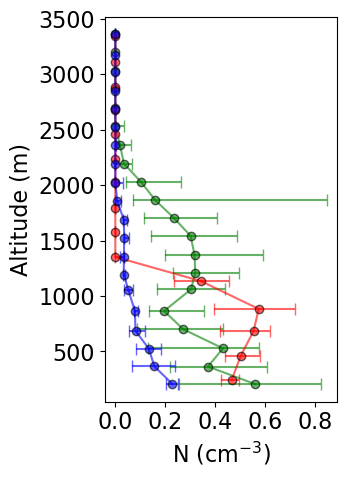

In [243]:
fig, ax = plt.subplots(figsize=(3, 5))
ax.errorbar(Caribbean_transport_median['N_FCDP'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['N_FCDP'], Caribbean_transport_75['N_FCDP']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'Caribbeann')
ax.errorbar(North_America_transport_median['N_FCDP'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['N_FCDP'], North_America_transport_75['N_FCDP']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax.errorbar(ocean_transport_median['N_FCDP'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['N_FCDP'], ocean_transport_75['N_FCDP']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'ocean')

ax.set_xlabel('N (cm$^{-3}$)', fontsize = 16)
ax.set_ylabel('Altitude (m)', fontsize = 16)
plt.xticks(fontsize=16)  # Set tick label size for x-axis
plt.yticks(fontsize=16)  # Set tick label size for y-axis
#fig.suptitle('f(RH)', fontsize=16)

#ax.legend()

In [ ]:
import pandas as pd

# Create a dictionary of DataFrames with their corresponding species names
data_frames = {
    'Caribbeann': Caribbean_transport_median,
    'North America': North_America_transport_median,
    'Ocean': ocean_transport_median
}

# Concatenate the DataFrames along rows (axis=0) and add a 'species' column based on the keys
concatenated_data = pd.concat(data_frames.values(), keys=data_frames.keys(), names=['species'])

# Reset the index if needed
concatenated_data.reset_index(inplace=True)
concatenated_data

# Now, the 'species' column will contain the names of the original DataFrames


In [ ]:
import seaborn as sns

# Load the penguins dataset
#penguins = sns.load_dataset("penguins")

# Create a joint PDF plot
g = sns.jointplot(data=concatenated_data, x="N_FCDP", y="GPS_Altitude_THORNHILL", hue="species")
# Limit the y-axis range to not exceed 4000
# Show the plot
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a joint PDF plot
g = sns.jointplot(data=concatenated_data, x="N_FCDP", y="GPS_Altitude_THORNHILL", hue="species")

# Set the y-axis limit to not exceed 4000
g.ax_joint.set_ylim(0, 3500)

# Show the plot
plt.show()


In [ ]:
import seaborn as sns

# Load the penguins dataset
#penguins = sns.load_dataset("penguins")

# Create a joint PDF plot
sns.jointplot(data=concatenated_data, x="N_FCDP", y="GPS_Altitude_THORNHILL", hue="species",  kind="kde")

# Show the plot
plt.show()


In [ ]:
# Concatenate the dataframes vertically (along rows)
cab = pd.concat([DAY1000_subset_111b, DAY11b_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
cab.reset_index(drop=True, inplace=True)
cab

In [ ]:
# Concatenate the dataframes vertically (along rows)
Cab2 = pd.concat([DAY1000_subset_133, DAY13_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Cab2.reset_index(drop=True, inplace=True)
Cab2.describe()

In [ ]:
Afri = pd.concat([DAY1000_subset_133b, DAY13b_subset_3000])
# Reset the index of the DAY2b_subsetd dataframe
Afri.reset_index(drop=True, inplace=True)
Afri

In [ ]:
fig, ax = plt.subplots(figsize=(3, 5))
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(cab['N_FCDP_VOIGT']/1000000, cab['GPS_Altitude_THORNHILL'], color = "grey", label = '11b')
ax.plot(Cab2['N_FCDP_VOIGT']/1000000, Cab2['GPS_Altitude_THORNHILL'], color = "green", label = '13')
ax.plot(Afri['N_FCDP_VOIGT']/1000000, Afri['GPS_Altitude_THORNHILL'], color = "blue", label = '13b')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.set_xlabel('N (cm$^{-3}$)', fontsize = 16)
ax.set_ylabel('Altitude (m)', fontsize = 16)
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')